In [ ]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import importlib

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms

importlib.reload(icrms)



In [ ]:
def getParser(file):
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
    return parser

def assign_formula(parser, interval, timerange, refmasslist=None):
    #Function to build formula assignment lists
    #Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)    
        mass_spectrum.molecular_search_settings.ion_charge = 1

        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()

        if refmasslist:
            mass_spectrum.settings.min_calib_ppm_error = 10
            mass_spectrum.settings.max_calib_ppm_error = -10
            calfn = MzDomainCalibration(mass_spectrum, refmasslist)
            ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

            imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                        calib_ppm_error_threshold=(0, 2.0),
                                                        calib_snr_threshold=3)

            calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
    
    results=pd.concat(results,ignore_index=True)

    return(results)    


In [87]:
def plot_ms(df1, start_mz, end_mz, tstart=None, df2=None,df3=None, assignment= None, ax_ms=None, lbls=None, norm=False, labs=False, colors=None):   
    
    if ax_ms == None:
        _, ax = plt.subplots()
    
    else:
        ax = ax_ms

    if colors is not None:
        cols = colors
    else:
        cols = ['C0', 'C1', 'C2']
    mzrange= end_mz - start_mz

    if tstart != None:
        ms_t_int=df1[df1['Time'] == tstart]
    else:
        ms_t_int=df1

    ms_df = ms_t_int[((ms_t_int['Calibrated m/z']-start_mz)<mzrange) & ((ms_t_int['Calibrated m/z']-start_mz)>0)]


    if norm:

        pltcol = 'Normalized Peak Height'

    else:
        pltcol = 'Peak Height'

    
    if lbls is not None:
        labels = lbls
    else:
        labels = [None, None, None]

 
    _, stemlines1, _ =ax.stem('Calibrated m/z',pltcol,data=ms_df,  markerfmt=' ', basefmt=' ', linefmt=cols[0], label = labels[0])
    
    if (df2 is not None) and (len(df2['Molecular Formula'])>0):
        pltdf2 = True
        if tstart != None:
            ms_t_int2=df2[df2['Time'] == tstart]
        else:
            ms_t_int2=df2

        ms_df2 = ms_t_int2[(abs(ms_t_int2['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int2['Calibrated m/z']-start_mz)>0)]
        
        _, stemlines2, _ =ax.stem('Calibrated m/z',pltcol,data=ms_df2,  markerfmt=' ', basefmt=' ', linefmt=cols[1], label = labels[1])
    else:
        pltdf2 = False 

    if (df3 is not None) and (len(df3['Molecular Formula'])>0):
        pltdf3 = True
        if tstart != None:
            ms_t_int3=df3[df3['Time'] == tstart]
        else:
            ms_t_int3=df3

        ms_df3 = ms_t_int3[(abs(ms_t_int3['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int3['Calibrated m/z']-start_mz)>0)]

        
        _, stemlines3, _ =ax.stem('Calibrated m/z',pltcol,data=ms_df3,  markerfmt=' ', basefmt=' ', linefmt=cols[2], label = labels[2])
    else:
        pltdf3 = False
    #if pltdf3 is True:
    #    ax.set_ylim(0, max([maxdf1, maxdf2, maxdf3]) * 1.1)
    #elif pltdf2 is True:
    #    ax.set_ylim(0, max([maxdf1, maxdf2]) * 1.1)
    #else: 
    #    ax.set_ylim(0, maxdf1 * 1.1)

    ax.set_xlim(left = start_mz - mzrange*0.1, right = start_mz + mzrange + mzrange*0.1) 

    if labs:
        for mzr,peakr,mf,er in zip(ms_df['Calibrated m/z'], ms_df[pltcol], ms_df['Molecular Formula'],  ms_df['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

            mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
            ax.text(mzr, peakr + 0.02 *max(ms_df[pltcol]), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color=cols[0])

        if df2 is not None:

            for mzr,peakr,mf, er in zip(ms_df2['Calibrated m/z'], ms_df2[pltcol], ms_df2['Molecular Formula'], ms_df2['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df2[pltcol]), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[1])

        if df3 is not None:

            for mzr,peakr,mf, er in zip(ms_df3['Calibrated m/z'], ms_df3[pltcol], ms_df3['Molecular Formula'], ms_df3['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df3[pltcol]), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[2])

   # theor_mz=pattern.mdiff+result['mass']
   # theor_int=pattern.ratio*result['abundance']
   # ax.stem(theor_mz,theor_int, basefmt=' ',linefmt='gray')

   # for isotope in pattern.isotope[pattern.requirement=='Y']:
   #     ax.stem('mz','intense',data=result[isotope],  markerfmt=' ', basefmt=' ',linefmt='red')
    ax.set_xlim(start_mz, end_mz)
    
    if ax == None:

        ax.legend(('other', 'target'),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)

        if(assignment):

            mf = assignment[0]
            score = assignment[1]
            er = assignment[2]

            ax.text(1.05,0.7,mf,transform=ax.transAxes)
            ax.text(1.05,0.6,'Error (ppm) = %.3f ' %er ,transform=ax.transAxes)
            ax.text(1.05,0.5,'Score = %.3f' %score ,transform=ax.transAxes)

    if norm: 
        ax.set(xlabel='Calibrated m/z',ylabel='Normalized Intensity')
    else: 
        ax.set(xlabel='Calibrated m/z',ylabel='Intensity')
    #ax.set_title('%.2f' %timerange[0] + ' to %.2f' %timerange[1] +' min', fontsize = 'medium')
    ax.legend(bbox_to_anchor = (1.00, 0.5), frameon =False, loc = 'center left')
    ax.axhline(y=0.0, color='black')
    plt.setp(stemlines1,'color', cols[0], 'linewidth', 2)
    if pltdf2 is True:
        plt.setp(stemlines2, 'color', cols[1],'linewidth', 2, 'linestyle', '--')
    if pltdf3 is True:
        plt.setp(stemlines3, 'color', cols[2],'linewidth', 2)
    plt.tight_layout()
    if ax_ms != None:
        return ax






In [52]:

def filterMzRange(results, mz_range):

    mz_i = mz_range[0]
    mz_f = mz_range[1]

    sub = results[(results['m/z'] >= mz_i) & (results['m/z'] <= mz_f)]

    return sub



In [ ]:
def pltMZerror(results, bins=50):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        counts, bins = np.histogram(np.asarray(results[results['mol_class']==mol_class]['m/z Error (ppm)']),bins = bins)

        ax.plot(bins[:-1], counts, label = mol_class)

    ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False)
    ax.set_xlabel('m/z assignment error (ppm)')
    ax.set_ylabel('# assigned features')

    return ax

def pltMZerror_pts(results):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        ax.scatter(results[results['mol_class']==mol_class]['Calibrated m/z'], results[results['mol_class']==mol_class]['m/z Error (ppm)'], label = mol_class)

    ax.set_xlim(200,1200)
    ax.legend(frameon=False,bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel('calibrated m/z')
    ax.set_ylabel('assignment error (ppm)')

    return ax


In [10]:
def assignMolClass(resultsdf, mz_cutoff = 800, sn_lim = 3):

    filtered_results=resultsdf[(resultsdf['m/z']<mz_cutoff) & (resultsdf['S/N']>sn_lim)]

    filtered_results['N']=filtered_results['N'].fillna(0)
    filtered_results['O']=filtered_results['O'].fillna(0)
    #filtered_results['S']=filtered_results['S'].fillna(0)
    #filtered_results['P']=filtered_results['Fe'].fillna(0)
    filtered_results['Cu']=filtered_results['Cu'].fillna(0)

    filtered_results['mol_class']='Unassigned'
    filtered_results['mol_class'][filtered_results['C']>0]='CHO'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['N']>0.5)]='CHON'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['S']>0.5)]='CHOS'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Fe']>0.5)]='CHOFe'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5)]='CHOCu'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5)]='CHONCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['S']>0.5)]='CHOSCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5) & (filtered_results['S']>0.5)] ='CHONSCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONNa'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONPNa'


    results= filtered_results #[filtered_results['mol_class'] != 'Unassigned'] #[filtered_results['Is Isotopologue']==0]
    results['N/C']=results['O']/results['C']
    results['H/C']=results['H']/results['C']
    results['N/C']=results['N']/results['C']

    return results



In [11]:
def add_mzwindow_col(df):    

    df['m/z window'] = df.index
    
    
    for file, r in zip(df['file'], range(len(df['file']))):

        if ('400_500' in file) or ('400-500' in file):

            df['m/z window'].iloc[r] = '400-500 m/z'

        elif ('500_600' in file) or ('500-600' in file):

            df['m/z window'].iloc[r] = '500-600 m/z'
    
        elif ('600_700' in file) or ('600-700' in file):

            df['m/z window'].iloc[r] = '600-700 m/z'

        elif ('700_800' in file) or ('700-800' in file):

            df['m/z window'].iloc[r] = '700-800 m/z'

        elif ('400_600' in file) or ('400-600' in file):

            df['m/z window'].iloc[r] = '400-600 m/z'
        
        elif ('600_800' in file) or ('600-800' in file):

            df['m/z window'].iloc[r] = '600-800 m/z'
            
        elif 'full' in file:

            df['m/z window'].iloc[r] = '200-1200 m/z'

    return df 

In [12]:
def getUniqueFeatures(df):    
    #Create a list of all unique features and describe their intensity. 
    print('total # results: %s' %len(df))
    #define a list of unique features (time, formula) with 'areas' determined for each sample. There may be a slight bug that causes the unique list to grow...
    uniquelist=[]
    for time in df.Time.unique():
        current=df[df.Time==time]
        current=current.sort_values(by=['m/z Error (ppm)'],ascending=True)
        currentunique=current.drop_duplicates(subset=['Molecular Formula'])
        currentunique=currentunique[currentunique['C']>1]
        currentunique=currentunique.set_index(['Molecular Formula'],drop=False)
        for file in df['file'].unique():
            current_file=current[current['file']==file].drop_duplicates(subset=['Molecular Formula'])
            current_file=current_file.rename(columns={'Peak Height':file})
            current_file=current_file.set_index(['Molecular Formula'],drop=False)
            #current_file[file].fillna(0)
            currentunique=currentunique.join(current_file[file])
        uniquelist.append(currentunique)

    unique_results=pd.concat(uniquelist,ignore_index=True)
    unique_results['N/C']=unique_results['N']/unique_results['C']
    #unique_results['blank']=unique_results[blankfile]/unique_results['Peak Height']
    #unique_results=unique_results[unique_results['blank']<blnk_thresh]


    print('# unique results: %s' %len(unique_results))

    return unique_results


In [13]:
def plotUnique(df,ps=50,includeBlanks=False, xlim = [400,600]):
    xmin = xlim[0]
    xmax = xlim[1]
    if includeBlanks != True:
        mask = ~df['file'].str.contains('qh2o', case=False, na=False)
        df=df[mask]
    else:
        df=df
    fig, ((ax2, ax4),(ax3, ax1)) = plt.subplots(2,2,figsize = (12,12))
    sns.scatterplot(x='m/z',y='m/z Error (ppm)',data=df[df['Cu']>0],hue='m/z window', s=ps*4, ax=ax1)
    sns.scatterplot(x='m/z',y='m/z Error (ppm)', hue='m/z window', data=df, ax=ax2,s=ps)
    ax1.set_xlim(xmin,xmax)
    ax2.set_xlim(xmin,xmax)
    sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='N',data=df,ax=ax3,s=ps)
    sns.scatterplot(x='m/z',y='Resolving Power',hue='mol_class',data=df,ax=ax4)
    
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_title('Assignment error, Cu features')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_title('Overall assignment error')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.set_title('Assignment error, N features')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.set_title('Resolving power v. m/z')

    #fig.savefig('unique_results.pdf', bbox_to_inches='tight')

    return fig

    

In [14]:
def addRepCol(data_df):

    data_df['Rep'] = data_df.index


    for file in data_df['file'].unique():

        print(file)

        if 'rep2' in file:

            temp = data_df[data_df['file'] == file]
            temp['Rep'] = 2
            data_df[data_df['file'] == file] = temp


        else:

            temp = data_df[data_df['file'] == file]
            temp['Rep'] = 1
            data_df[data_df['file'] == file] = temp

    print(data_df['Rep'].unique())


    return data_df 

In [15]:
def blankSubtract(df, blnkthresh = 0.9):
    
    holder = []
    for file in df['file'].unique():
        
        sub = df[df['file'] == file]

        blkf = sub['blank file'].iloc[0]


        sub[sub[file]== np.nan] = 0

        nom = sub[file]
        den = sub[blkf]

        nom = nom.replace(np.nan,0)
        den = den.replace(np.nan,1)

        if file != blkf:
            nom = nom
        elif file == blkf:
            nom = nom * (blnkthresh*0.8)

        sub['blank subtract'] = nom/den
        holder.append(sub)
    df_end = pd.concat(holder)
    df_end = df_end[df_end['blank subtract'] > blnkthresh]
    return df_end

In [89]:
def normMS(df,fulldf):

    max_i = max(fulldf['Peak Height'].values)

    df['Normalized Peak Height'] = df['Peak Height'] / max_i

    return df

In [16]:
#import data
#dir = 'C:\\Users\\deweyc\Box\\Boiteau Lab\\Mass Spec Data\\21T at NHMFL\\2022-10 Nicole & Christian\\Christian\\spring-a'
dir='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/lowmz'
#file_location='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2021_August_OC2102A/OC2012A/'
flist=os.listdir(dir)
os.chdir(dir)

print(flist)
MSfiles={}

for f in flist:
    if '.raw' in f:
        print(f)
        parser = rawFileReader.ImportMassSpectraThermoMSFileReader(f)
        MSfiles[f]={'parser': parser}


['20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw', 'all_results.pdf', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw', 'db', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw']
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw
2

In [17]:
data = icrms.lc_icr_assign(dir)

data.master_data_holder = MSfiles

print(data.master_data_holder.keys())
data._raw_filelist = data.master_data_holder.keys()


dict_keys(['20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw'])


In [18]:
# set assignment parameters
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"


MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,2)
MSParameters.molecular_search.usedAtoms['Cu'] = (0,1)
MSParameters.molecular_search.usedAtoms['S'] = (0,0)

In [19]:
# run assignment algorithm
timerange = [2,30]  # start (min) to stop (min)
interval = 2  # min 
refmasslist = "/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref"

data.assign_formula(interval = interval, timerange = timerange, refmasslist = refmasslist)




20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw
1 of 14 files
timestart: 2
MS Obj loaded - 662 peaks found.
MS Obj loaded - 662 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  26.41 ms


Loading molecular formula database: 100118it [00:03, 30784.88it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 303.84it/s]


'run_molecular_formula'  3742.70 ms
19 assigned peaks and 643 unassigned peaks, total  = 2.87 %, relative abundance = 1.89 %, RMS error (best candidate) (ppm) = 0.141
timestart: 4
MS Obj loaded - 1338 peaks found.
MS Obj loaded - 1338 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.65 ms


Loading molecular formula database: 100118it [00:03, 30367.95it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 151.36it/s]


'run_molecular_formula'  4145.99 ms
576 assigned peaks and 762 unassigned peaks, total  = 43.05 %, relative abundance = 39.16 %, RMS error (best candidate) (ppm) = 0.085
timestart: 6
MS Obj loaded - 2608 peaks found.
MS Obj loaded - 2608 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
14 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 264 fn evals and 3 iterations
'runworker'  5.49 ms


Loading molecular formula database: 100118it [00:03, 28646.06it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 78.59it/s]


'run_molecular_formula'  5091.98 ms
1320 assigned peaks and 1288 unassigned peaks, total  = 50.61 %, relative abundance = 57.28 %, RMS error (best candidate) (ppm) = 0.066
timestart: 8
MS Obj loaded - 3507 peaks found.
MS Obj loaded - 3507 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
72 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 168 fn evals and 2 iterations
'runworker'  5.57 ms


Loading molecular formula database: 100118it [00:04, 24706.61it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 57.75it/s]


'run_molecular_formula'  6211.47 ms
1815 assigned peaks and 1692 unassigned peaks, total  = 51.75 %, relative abundance = 62.36 %, RMS error (best candidate) (ppm) = 0.045
timestart: 10
MS Obj loaded - 3843 peaks found.
MS Obj loaded - 3843 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
173 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  5.19 ms


Loading molecular formula database: 100118it [00:04, 24730.43it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 52.41it/s]


'run_molecular_formula'  6420.27 ms
2208 assigned peaks and 1635 unassigned peaks, total  = 57.46 %, relative abundance = 69.73 %, RMS error (best candidate) (ppm) = 0.037
timestart: 12
MS Obj loaded - 4248 peaks found.
MS Obj loaded - 4248 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
199 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  5.62 ms


Loading molecular formula database: 100118it [00:04, 24551.77it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 46.72it/s]


'run_molecular_formula'  6735.23 ms
2573 assigned peaks and 1675 unassigned peaks, total  = 60.57 %, relative abundance = 73.84 %, RMS error (best candidate) (ppm) = 0.038
timestart: 14
MS Obj loaded - 4577 peaks found.
MS Obj loaded - 4577 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
235 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 320 fn evals and 6 iterations
'runworker'  6.01 ms


Loading molecular formula database: 100118it [00:04, 23421.34it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 43.48it/s]


'run_molecular_formula'  7126.14 ms
2931 assigned peaks and 1646 unassigned peaks, total  = 64.04 %, relative abundance = 78.18 %, RMS error (best candidate) (ppm) = 0.040
timestart: 16
MS Obj loaded - 4580 peaks found.
MS Obj loaded - 4580 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
251 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  6.41 ms


Loading molecular formula database: 100118it [00:04, 22067.16it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 43.48it/s]


'run_molecular_formula'  7388.15 ms
2912 assigned peaks and 1668 unassigned peaks, total  = 63.58 %, relative abundance = 80.49 %, RMS error (best candidate) (ppm) = 0.049
timestart: 18
MS Obj loaded - 5111 peaks found.
MS Obj loaded - 5111 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
267 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 3034 fn evals and 69 iterations
'runworker'  5.41 ms


Loading molecular formula database: 100118it [00:04, 23623.91it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:03<00:00, 35.71it/s]


'run_molecular_formula'  7662.60 ms
3294 assigned peaks and 1817 unassigned peaks, total  = 64.45 %, relative abundance = 81.87 %, RMS error (best candidate) (ppm) = 0.050
timestart: 20
MS Obj loaded - 4924 peaks found.
MS Obj loaded - 4924 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
259 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 325 fn evals and 6 iterations
'runworker'  5.41 ms


Loading molecular formula database: 100118it [00:04, 23321.10it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:03<00:00, 39.71it/s]


'run_molecular_formula'  7405.57 ms
3285 assigned peaks and 1639 unassigned peaks, total  = 66.71 %, relative abundance = 82.89 %, RMS error (best candidate) (ppm) = 0.054
timestart: 22
MS Obj loaded - 3750 peaks found.
MS Obj loaded - 3750 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
227 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.014 ppm
minimize function performed 480 fn evals and 10 iterations
'runworker'  7.39 ms


Loading molecular formula database: 100118it [00:03, 25434.62it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 53.81it/s]


'run_molecular_formula'  6248.00 ms
2800 assigned peaks and 950 unassigned peaks, total  = 74.67 %, relative abundance = 78.00 %, RMS error (best candidate) (ppm) = 0.040
timestart: 24
MS Obj loaded - 3158 peaks found.
MS Obj loaded - 3158 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
211 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 328 fn evals and 6 iterations
'runworker'  5.72 ms


Loading molecular formula database: 100118it [00:03, 25324.86it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 64.85it/s]


'run_molecular_formula'  5882.64 ms
2382 assigned peaks and 776 unassigned peaks, total  = 75.43 %, relative abundance = 82.49 %, RMS error (best candidate) (ppm) = 0.032
timestart: 26
MS Obj loaded - 4022 peaks found.
MS Obj loaded - 4022 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
197 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 376 fn evals and 8 iterations
'runworker'  5.20 ms


Loading molecular formula database: 100118it [00:04, 24331.69it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 52.25it/s]


'run_molecular_formula'  6492.90 ms
2530 assigned peaks and 1492 unassigned peaks, total  = 62.90 %, relative abundance = 72.90 %, RMS error (best candidate) (ppm) = 0.043
timestart: 28
MS Obj loaded - 1797 peaks found.
MS Obj loaded - 1797 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
82 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.154 ppm
minimize function performed 263 fn evals and 3 iterations
'runworker'  7.48 ms


Loading molecular formula database: 100118it [00:03, 26633.37it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 119.08it/s]


'run_molecular_formula'  4838.96 ms
935 assigned peaks and 862 unassigned peaks, total  = 52.03 %, relative abundance = 52.77 %, RMS error (best candidate) (ppm) = 0.050


20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw
2 of 14 files
timestart: 2
MS Obj loaded - 327 peaks found.
MS Obj loaded - 327 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.50 ms


Loading molecular formula database: 100118it [00:02, 44677.19it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 632.44it/s]


'run_molecular_formula'  2454.77 ms
0 assigned peaks and 327 unassigned peaks, total  = 0.00 %, relative abundance = 0.00 %, RMS error (best candidate) (ppm) = nan
timestart: 4
MS Obj loaded - 1022 peaks found.
MS Obj loaded - 1022 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.73 ms


Loading molecular formula database: 100118it [00:02, 36458.41it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 214.32it/s]


'run_molecular_formula'  3332.57 ms
235 assigned peaks and 787 unassigned peaks, total  = 22.99 %, relative abundance = 22.25 %, RMS error (best candidate) (ppm) = 0.226
timestart: 6
MS Obj loaded - 1654 peaks found.
MS Obj loaded - 1654 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.68 ms


Loading molecular formula database: 100118it [00:02, 43559.74it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 131.64it/s]


'run_molecular_formula'  3236.72 ms
749 assigned peaks and 905 unassigned peaks, total  = 45.28 %, relative abundance = 55.47 %, RMS error (best candidate) (ppm) = 0.124
timestart: 8
MS Obj loaded - 2021 peaks found.
MS Obj loaded - 2021 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
5 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.001 ppm
minimize function performed 181 fn evals and 2 iterations
'runworker'  5.18 ms


Loading molecular formula database: 100118it [00:02, 40408.43it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 106.77it/s]


'run_molecular_formula'  3627.47 ms
964 assigned peaks and 1057 unassigned peaks, total  = 47.70 %, relative abundance = 61.92 %, RMS error (best candidate) (ppm) = 0.076
timestart: 10
MS Obj loaded - 2086 peaks found.
MS Obj loaded - 2086 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
49 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 625 fn evals and 9 iterations
'runworker'  5.85 ms


Loading molecular formula database: 100118it [00:02, 41754.16it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 104.97it/s]


'run_molecular_formula'  3567.47 ms
1096 assigned peaks and 990 unassigned peaks, total  = 52.54 %, relative abundance = 65.76 %, RMS error (best candidate) (ppm) = 0.041
timestart: 12
MS Obj loaded - 2358 peaks found.
MS Obj loaded - 2358 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
90 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.014 ppm
minimize function performed 393 fn evals and 7 iterations
'runworker'  5.36 ms


Loading molecular formula database: 100118it [00:02, 42130.26it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 92.80it/s]


'run_molecular_formula'  3695.88 ms
1261 assigned peaks and 1097 unassigned peaks, total  = 53.48 %, relative abundance = 70.79 %, RMS error (best candidate) (ppm) = 0.040
timestart: 14
MS Obj loaded - 2606 peaks found.
MS Obj loaded - 2606 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  5.93 ms


Loading molecular formula database: 100118it [00:02, 38176.88it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 82.84it/s]


'run_molecular_formula'  4097.75 ms
1427 assigned peaks and 1179 unassigned peaks, total  = 54.76 %, relative abundance = 75.50 %, RMS error (best candidate) (ppm) = 0.044
timestart: 16
MS Obj loaded - 2498 peaks found.
MS Obj loaded - 2498 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
116 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  5.50 ms


Loading molecular formula database: 100118it [00:02, 41684.43it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 87.01it/s]


'run_molecular_formula'  3807.93 ms
1451 assigned peaks and 1047 unassigned peaks, total  = 58.09 %, relative abundance = 78.36 %, RMS error (best candidate) (ppm) = 0.042
timestart: 18
MS Obj loaded - 2429 peaks found.
MS Obj loaded - 2429 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
120 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 377 fn evals and 7 iterations
'runworker'  5.67 ms


Loading molecular formula database: 100118it [00:02, 42157.83it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 88.09it/s]


'run_molecular_formula'  3763.52 ms
1509 assigned peaks and 920 unassigned peaks, total  = 62.12 %, relative abundance = 81.57 %, RMS error (best candidate) (ppm) = 0.047
timestart: 20
MS Obj loaded - 2374 peaks found.
MS Obj loaded - 2374 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
117 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 376 fn evals and 7 iterations
'runworker'  5.26 ms


Loading molecular formula database: 100118it [00:02, 37981.52it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 90.68it/s]


'run_molecular_formula'  3985.30 ms
1564 assigned peaks and 810 unassigned peaks, total  = 65.88 %, relative abundance = 83.62 %, RMS error (best candidate) (ppm) = 0.047
timestart: 22
MS Obj loaded - 2363 peaks found.
MS Obj loaded - 2363 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
112 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 366 fn evals and 7 iterations
'runworker'  5.22 ms


Loading molecular formula database: 100118it [00:02, 41316.42it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 91.07it/s]


'run_molecular_formula'  3766.99 ms
1603 assigned peaks and 760 unassigned peaks, total  = 67.84 %, relative abundance = 84.08 %, RMS error (best candidate) (ppm) = 0.047
timestart: 24
MS Obj loaded - 1820 peaks found.
MS Obj loaded - 1820 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
97 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 375 fn evals and 7 iterations
'runworker'  5.51 ms


Loading molecular formula database: 100118it [00:02, 41305.68it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 117.19it/s]


'run_molecular_formula'  3474.40 ms
1322 assigned peaks and 498 unassigned peaks, total  = 72.64 %, relative abundance = 84.96 %, RMS error (best candidate) (ppm) = 0.038
timestart: 26
MS Obj loaded - 2265 peaks found.
MS Obj loaded - 2265 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
100 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 376 fn evals and 7 iterations
'runworker'  7.24 ms


Loading molecular formula database: 100118it [00:02, 41485.64it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 94.94it/s]


'run_molecular_formula'  3705.30 ms
1390 assigned peaks and 875 unassigned peaks, total  = 61.37 %, relative abundance = 76.42 %, RMS error (best candidate) (ppm) = 0.053
timestart: 28
MS Obj loaded - 1123 peaks found.
MS Obj loaded - 1123 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
41 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.011 ppm
minimize function performed 847 fn evals and 12 iterations
'runworker'  5.72 ms


Loading molecular formula database: 100118it [00:02, 38415.08it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 186.50it/s]


'run_molecular_formula'  3276.12 ms
654 assigned peaks and 469 unassigned peaks, total  = 58.24 %, relative abundance = 52.22 %, RMS error (best candidate) (ppm) = 0.034


20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
3 of 14 files
timestart: 2
MS Obj loaded - 521 peaks found.
MS Obj loaded - 521 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.84 ms


Loading molecular formula database: 100118it [00:02, 39205.15it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 376.42it/s]


'run_molecular_formula'  2908.08 ms
1 assigned peaks and 520 unassigned peaks, total  = 0.19 %, relative abundance = 0.10 %, RMS error (best candidate) (ppm) = 0.092
timestart: 4
MS Obj loaded - 1268 peaks found.
MS Obj loaded - 1268 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.24 ms


Loading molecular formula database: 100118it [00:02, 33823.58it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 162.87it/s]


'run_molecular_formula'  3737.28 ms
127 assigned peaks and 1141 unassigned peaks, total  = 10.02 %, relative abundance = 4.20 %, RMS error (best candidate) (ppm) = 0.215
timestart: 6
MS Obj loaded - 2128 peaks found.
MS Obj loaded - 2128 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.17 ms


Loading molecular formula database: 100118it [00:02, 34993.19it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 92.95it/s]


'run_molecular_formula'  4193.64 ms
989 assigned peaks and 1139 unassigned peaks, total  = 46.48 %, relative abundance = 53.11 %, RMS error (best candidate) (ppm) = 0.131
timestart: 8
MS Obj loaded - 2816 peaks found.
MS Obj loaded - 2816 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
5 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.014 ppm
minimize function performed 275 fn evals and 3 iterations
'runworker'  7.10 ms


Loading molecular formula database: 100118it [00:02, 34868.35it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 70.22it/s]


'run_molecular_formula'  4624.20 ms
1374 assigned peaks and 1442 unassigned peaks, total  = 48.79 %, relative abundance = 61.14 %, RMS error (best candidate) (ppm) = 0.126
timestart: 10
MS Obj loaded - 3077 peaks found.
MS Obj loaded - 3077 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
80 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 365 fn evals and 7 iterations
'runworker'  5.37 ms


Loading molecular formula database: 100118it [00:03, 32758.04it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 64.22it/s]


'run_molecular_formula'  4966.91 ms
1666 assigned peaks and 1411 unassigned peaks, total  = 54.14 %, relative abundance = 65.62 %, RMS error (best candidate) (ppm) = 0.049
timestart: 12
MS Obj loaded - 3549 peaks found.
MS Obj loaded - 3549 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
102 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 372 fn evals and 7 iterations
'runworker'  5.23 ms


Loading molecular formula database: 100118it [00:02, 36262.06it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 55.59it/s]


'run_molecular_formula'  4962.25 ms
1992 assigned peaks and 1557 unassigned peaks, total  = 56.13 %, relative abundance = 69.97 %, RMS error (best candidate) (ppm) = 0.044
timestart: 14
MS Obj loaded - 3768 peaks found.
MS Obj loaded - 3768 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
126 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 373 fn evals and 7 iterations
'runworker'  5.61 ms


Loading molecular formula database: 100118it [00:02, 33420.10it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 51.94it/s]


'run_molecular_formula'  5348.69 ms
2226 assigned peaks and 1542 unassigned peaks, total  = 59.08 %, relative abundance = 75.30 %, RMS error (best candidate) (ppm) = 0.049
timestart: 16
MS Obj loaded - 3452 peaks found.
MS Obj loaded - 3452 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
160 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 361 fn evals and 7 iterations
'runworker'  7.38 ms


Loading molecular formula database: 100118it [00:02, 33838.84it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 56.68it/s]


'run_molecular_formula'  5119.70 ms
2211 assigned peaks and 1241 unassigned peaks, total  = 64.05 %, relative abundance = 78.34 %, RMS error (best candidate) (ppm) = 0.047
timestart: 18
MS Obj loaded - 3759 peaks found.
MS Obj loaded - 3759 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
161 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 361 fn evals and 7 iterations
'runworker'  5.58 ms


Loading molecular formula database: 100118it [00:02, 34950.12it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 51.77it/s]


'run_molecular_formula'  5225.19 ms
2459 assigned peaks and 1300 unassigned peaks, total  = 65.42 %, relative abundance = 80.73 %, RMS error (best candidate) (ppm) = 0.049
timestart: 20
MS Obj loaded - 3919 peaks found.
MS Obj loaded - 3919 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
167 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 361 fn evals and 7 iterations
'runworker'  7.39 ms


Loading molecular formula database: 100118it [00:02, 33527.72it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 49.20it/s]


'run_molecular_formula'  5469.87 ms
2611 assigned peaks and 1308 unassigned peaks, total  = 66.62 %, relative abundance = 82.57 %, RMS error (best candidate) (ppm) = 0.052
timestart: 22
MS Obj loaded - 3817 peaks found.
MS Obj loaded - 3817 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
155 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 364 fn evals and 7 iterations
'runworker'  5.61 ms


Loading molecular formula database: 100118it [00:02, 34785.33it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 50.75it/s]


'run_molecular_formula'  5285.46 ms
2642 assigned peaks and 1175 unassigned peaks, total  = 69.22 %, relative abundance = 83.14 %, RMS error (best candidate) (ppm) = 0.055
timestart: 24
MS Obj loaded - 3250 peaks found.
MS Obj loaded - 3250 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
139 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 363 fn evals and 7 iterations
'runworker'  5.17 ms


Loading molecular formula database: 100118it [00:03, 32768.69it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 59.92it/s]


'run_molecular_formula'  5100.34 ms
2359 assigned peaks and 891 unassigned peaks, total  = 72.58 %, relative abundance = 83.61 %, RMS error (best candidate) (ppm) = 0.046
timestart: 26
MS Obj loaded - 3616 peaks found.
MS Obj loaded - 3616 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
126 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  5.58 ms


Loading molecular formula database: 100118it [00:02, 34643.88it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 53.87it/s]


'run_molecular_formula'  5160.48 ms
2270 assigned peaks and 1346 unassigned peaks, total  = 62.78 %, relative abundance = 77.03 %, RMS error (best candidate) (ppm) = 0.048
timestart: 28
MS Obj loaded - 1851 peaks found.
MS Obj loaded - 1851 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
72 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 368 fn evals and 7 iterations
'runworker'  5.68 ms


Loading molecular formula database: 100118it [00:02, 35063.35it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 106.33it/s]


'run_molecular_formula'  4025.67 ms
1082 assigned peaks and 769 unassigned peaks, total  = 58.45 %, relative abundance = 52.10 %, RMS error (best candidate) (ppm) = 0.041


20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw
4 of 14 files
timestart: 2
MS Obj loaded - 87 peaks found.
MS Obj loaded - 87 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.12 ms


Loading molecular formula database: 100118it [00:02, 41379.26it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1208.68it/s]


'run_molecular_formula'  2542.24 ms
15 assigned peaks and 72 unassigned peaks, total  = 17.24 %, relative abundance = 10.14 %, RMS error (best candidate) (ppm) = 0.129
timestart: 4
MS Obj loaded - 95 peaks found.
MS Obj loaded - 95 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.30 ms


Loading molecular formula database: 100118it [00:02, 46486.73it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1132.89it/s]


'run_molecular_formula'  2284.38 ms
18 assigned peaks and 77 unassigned peaks, total  = 18.95 %, relative abundance = 11.36 %, RMS error (best candidate) (ppm) = 0.144
timestart: 6
MS Obj loaded - 126 peaks found.
MS Obj loaded - 126 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.81 ms


Loading molecular formula database: 100118it [00:02, 41034.80it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 936.57it/s]


'run_molecular_formula'  2593.49 ms
37 assigned peaks and 89 unassigned peaks, total  = 29.37 %, relative abundance = 13.69 %, RMS error (best candidate) (ppm) = 0.136
timestart: 8
MS Obj loaded - 202 peaks found.
MS Obj loaded - 202 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.60 ms


Loading molecular formula database: 100118it [00:02, 40942.17it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 686.83it/s]


'run_molecular_formula'  2646.62 ms
50 assigned peaks and 152 unassigned peaks, total  = 24.75 %, relative abundance = 13.20 %, RMS error (best candidate) (ppm) = 0.138
timestart: 10
MS Obj loaded - 141 peaks found.
MS Obj loaded - 141 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.59 ms


Loading molecular formula database: 100118it [00:02, 41808.68it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 844.39it/s]


'run_molecular_formula'  2561.44 ms
56 assigned peaks and 85 unassigned peaks, total  = 39.72 %, relative abundance = 16.18 %, RMS error (best candidate) (ppm) = 0.132
timestart: 12
MS Obj loaded - 159 peaks found.
MS Obj loaded - 159 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.46 ms


Loading molecular formula database: 100118it [00:02, 41429.00it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 779.40it/s]


'run_molecular_formula'  2595.75 ms
68 assigned peaks and 91 unassigned peaks, total  = 42.77 %, relative abundance = 13.17 %, RMS error (best candidate) (ppm) = 0.092
timestart: 14
MS Obj loaded - 191 peaks found.
MS Obj loaded - 191 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.44 ms


Loading molecular formula database: 100118it [00:02, 44311.41it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 679.69it/s]


'run_molecular_formula'  2462.34 ms
81 assigned peaks and 110 unassigned peaks, total  = 42.41 %, relative abundance = 18.63 %, RMS error (best candidate) (ppm) = 0.082
timestart: 16
MS Obj loaded - 265 peaks found.
MS Obj loaded - 265 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.37 ms


Loading molecular formula database: 100118it [00:02, 38634.21it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 507.59it/s]


'run_molecular_formula'  2855.09 ms
117 assigned peaks and 148 unassigned peaks, total  = 44.15 %, relative abundance = 23.50 %, RMS error (best candidate) (ppm) = 0.072
timestart: 18
MS Obj loaded - 141 peaks found.
MS Obj loaded - 141 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.44 ms


Loading molecular formula database: 100118it [00:02, 45222.03it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 873.35it/s]


'run_molecular_formula'  2375.73 ms
45 assigned peaks and 96 unassigned peaks, total  = 31.91 %, relative abundance = 9.44 %, RMS error (best candidate) (ppm) = 0.069
timestart: 20
MS Obj loaded - 254 peaks found.
MS Obj loaded - 254 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
3 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.000 ppm
minimize function performed 311 fn evals and 3 iterations
'runworker'  5.63 ms


Loading molecular formula database: 100118it [00:02, 39977.14it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 542.92it/s]


'run_molecular_formula'  2752.38 ms
124 assigned peaks and 130 unassigned peaks, total  = 48.82 %, relative abundance = 23.33 %, RMS error (best candidate) (ppm) = 0.062
timestart: 22
MS Obj loaded - 278 peaks found.
MS Obj loaded - 278 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.45 ms


Loading molecular formula database: 100118it [00:02, 41179.15it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 509.76it/s]


'run_molecular_formula'  2693.60 ms
127 assigned peaks and 151 unassigned peaks, total  = 45.68 %, relative abundance = 43.99 %, RMS error (best candidate) (ppm) = 0.136
timestart: 24
MS Obj loaded - 173 peaks found.
MS Obj loaded - 173 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.45 ms


Loading molecular formula database: 100118it [00:02, 41414.78it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 824.50it/s]


'run_molecular_formula'  2588.96 ms
10 assigned peaks and 163 unassigned peaks, total  = 5.78 %, relative abundance = 1.56 %, RMS error (best candidate) (ppm) = 0.149
timestart: 26
MS Obj loaded - 282 peaks found.
MS Obj loaded - 282 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.40 ms


Loading molecular formula database: 100118it [00:02, 40126.34it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 505.98it/s]


'run_molecular_formula'  2760.82 ms
57 assigned peaks and 225 unassigned peaks, total  = 20.21 %, relative abundance = 15.03 %, RMS error (best candidate) (ppm) = 0.193
timestart: 28
MS Obj loaded - 371 peaks found.
MS Obj loaded - 371 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.40 ms


Loading molecular formula database: 100118it [00:02, 39413.19it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 437.54it/s]


'run_molecular_formula'  2844.25 ms
11 assigned peaks and 360 unassigned peaks, total  = 2.96 %, relative abundance = 0.88 %, RMS error (best candidate) (ppm) = 0.116


20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
5 of 14 files
timestart: 2
MS Obj loaded - 751 peaks found.
MS Obj loaded - 751 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.18 ms


Loading molecular formula database: 100118it [00:03, 31627.70it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 272.51it/s]


'run_molecular_formula'  3655.60 ms
53 assigned peaks and 698 unassigned peaks, total  = 7.06 %, relative abundance = 3.67 %, RMS error (best candidate) (ppm) = 0.118
timestart: 4
MS Obj loaded - 1634 peaks found.
MS Obj loaded - 1634 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.49 ms


Loading molecular formula database: 100118it [00:03, 29891.09it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 126.56it/s]


'run_molecular_formula'  4358.85 ms
709 assigned peaks and 925 unassigned peaks, total  = 43.39 %, relative abundance = 40.37 %, RMS error (best candidate) (ppm) = 0.060
timestart: 6
MS Obj loaded - 2758 peaks found.
MS Obj loaded - 2758 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
66 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 1235 fn evals and 18 iterations
'runworker'  5.40 ms


Loading molecular formula database: 100118it [00:03, 27299.06it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 75.94it/s]


'run_molecular_formula'  5318.31 ms
1453 assigned peaks and 1305 unassigned peaks, total  = 52.68 %, relative abundance = 58.96 %, RMS error (best candidate) (ppm) = 0.031
timestart: 8
MS Obj loaded - 3769 peaks found.
MS Obj loaded - 3769 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
133 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 330 fn evals and 6 iterations
'runworker'  5.50 ms


Loading molecular formula database: 100118it [00:04, 24467.61it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 54.55it/s]


'run_molecular_formula'  6375.77 ms
1958 assigned peaks and 1811 unassigned peaks, total  = 51.95 %, relative abundance = 62.48 %, RMS error (best candidate) (ppm) = 0.036
timestart: 10
MS Obj loaded - 4003 peaks found.
MS Obj loaded - 4003 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
182 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  6.98 ms


Loading molecular formula database: 100118it [00:04, 24826.91it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 50.83it/s]


'run_molecular_formula'  6480.73 ms
2312 assigned peaks and 1691 unassigned peaks, total  = 57.76 %, relative abundance = 70.05 %, RMS error (best candidate) (ppm) = 0.038
timestart: 12
MS Obj loaded - 4329 peaks found.
MS Obj loaded - 4329 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
211 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  5.37 ms


Loading molecular formula database: 100118it [00:04, 22697.96it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 46.70it/s]


'run_molecular_formula'  7069.40 ms
2609 assigned peaks and 1720 unassigned peaks, total  = 60.27 %, relative abundance = 73.82 %, RMS error (best candidate) (ppm) = 0.041
timestart: 14
MS Obj loaded - 4619 peaks found.
MS Obj loaded - 4619 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
241 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 324 fn evals and 6 iterations
'runworker'  7.08 ms


Loading molecular formula database: 100118it [00:04, 24167.07it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 43.48it/s]


'run_molecular_formula'  6998.25 ms
2936 assigned peaks and 1683 unassigned peaks, total  = 63.56 %, relative abundance = 78.06 %, RMS error (best candidate) (ppm) = 0.044
timestart: 16
MS Obj loaded - 4899 peaks found.
MS Obj loaded - 4899 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
254 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 324 fn evals and 6 iterations
'runworker'  5.26 ms


Loading molecular formula database: 100118it [00:04, 22024.01it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 40.52it/s]


'run_molecular_formula'  7602.23 ms
3112 assigned peaks and 1787 unassigned peaks, total  = 63.52 %, relative abundance = 80.02 %, RMS error (best candidate) (ppm) = 0.047
timestart: 18
MS Obj loaded - 5289 peaks found.
MS Obj loaded - 5289 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
268 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  7.20 ms


Loading molecular formula database: 100118it [00:04, 22767.16it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:03<00:00, 37.36it/s]


'run_molecular_formula'  7707.43 ms
3389 assigned peaks and 1900 unassigned peaks, total  = 64.08 %, relative abundance = 81.29 %, RMS error (best candidate) (ppm) = 0.063
timestart: 20
MS Obj loaded - 5527 peaks found.
MS Obj loaded - 5527 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
262 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 3029 fn evals and 71 iterations
'runworker'  5.30 ms


Loading molecular formula database: 100118it [00:04, 22726.50it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:03<00:00, 35.64it/s]


'run_molecular_formula'  7867.91 ms
3631 assigned peaks and 1896 unassigned peaks, total  = 65.70 %, relative abundance = 81.86 %, RMS error (best candidate) (ppm) = 0.054
timestart: 22
MS Obj loaded - 4048 peaks found.
MS Obj loaded - 4048 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
230 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 503 fn evals and 10 iterations
'runworker'  5.62 ms


Loading molecular formula database: 100118it [00:04, 24766.23it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 50.02it/s]


'run_molecular_formula'  6526.11 ms
2959 assigned peaks and 1089 unassigned peaks, total  = 73.10 %, relative abundance = 76.11 %, RMS error (best candidate) (ppm) = 0.045
timestart: 24
MS Obj loaded - 3321 peaks found.
MS Obj loaded - 3321 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
211 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 331 fn evals and 6 iterations
'runworker'  5.27 ms


Loading molecular formula database: 100118it [00:04, 24781.07it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 62.07it/s]


'run_molecular_formula'  6053.06 ms
2421 assigned peaks and 900 unassigned peaks, total  = 72.90 %, relative abundance = 78.77 %, RMS error (best candidate) (ppm) = 0.036
timestart: 26
MS Obj loaded - 3403 peaks found.
MS Obj loaded - 3403 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
185 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.011 ppm
minimize function performed 336 fn evals and 6 iterations
'runworker'  5.19 ms


Loading molecular formula database: 100118it [00:04, 24823.66it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 62.48it/s]


'run_molecular_formula'  6034.75 ms
2212 assigned peaks and 1191 unassigned peaks, total  = 65.00 %, relative abundance = 66.67 %, RMS error (best candidate) (ppm) = 0.031
timestart: 28
MS Obj loaded - 1599 peaks found.
MS Obj loaded - 1599 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
66 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.172 ppm
minimize function performed 164 fn evals and 2 iterations
'runworker'  7.51 ms


Loading molecular formula database: 100118it [00:03, 27429.31it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 134.61it/s]


'run_molecular_formula'  4613.11 ms
793 assigned peaks and 806 unassigned peaks, total  = 49.59 %, relative abundance = 46.13 %, RMS error (best candidate) (ppm) = 0.055


20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
6 of 14 files
timestart: 2
MS Obj loaded - 357 peaks found.
MS Obj loaded - 357 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.45 ms


Loading molecular formula database: 100118it [00:02, 37835.29it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 591.36it/s]


'run_molecular_formula'  2873.20 ms
0 assigned peaks and 357 unassigned peaks, total  = 0.00 %, relative abundance = 0.00 %, RMS error (best candidate) (ppm) = nan
timestart: 4
MS Obj loaded - 1155 peaks found.
MS Obj loaded - 1155 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.20 ms


Loading molecular formula database: 100118it [00:02, 42412.01it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 186.99it/s]


'run_molecular_formula'  3029.65 ms
367 assigned peaks and 788 unassigned peaks, total  = 31.77 %, relative abundance = 34.65 %, RMS error (best candidate) (ppm) = 0.214
timestart: 6
MS Obj loaded - 1591 peaks found.
MS Obj loaded - 1591 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
2 calibration points matched within thresholds.
'runworker'  5.19 ms


Loading molecular formula database: 100118it [00:02, 39826.53it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 136.93it/s]


'run_molecular_formula'  3416.22 ms
750 assigned peaks and 841 unassigned peaks, total  = 47.14 %, relative abundance = 55.62 %, RMS error (best candidate) (ppm) = 0.082
timestart: 8
MS Obj loaded - 1981 peaks found.
MS Obj loaded - 1981 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
5 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 177 fn evals and 2 iterations
'runworker'  5.59 ms


Loading molecular formula database: 100118it [00:02, 37720.14it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 110.01it/s]


'run_molecular_formula'  3771.42 ms
963 assigned peaks and 1018 unassigned peaks, total  = 48.61 %, relative abundance = 62.42 %, RMS error (best candidate) (ppm) = 0.095
timestart: 10
MS Obj loaded - 2115 peaks found.
MS Obj loaded - 2115 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
58 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.011 ppm
minimize function performed 690 fn evals and 10 iterations
'runworker'  5.22 ms


Loading molecular formula database: 100118it [00:02, 42189.87it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 103.42it/s]


'run_molecular_formula'  3559.78 ms
1120 assigned peaks and 995 unassigned peaks, total  = 52.96 %, relative abundance = 66.00 %, RMS error (best candidate) (ppm) = 0.041
timestart: 12
MS Obj loaded - 2461 peaks found.
MS Obj loaded - 2461 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
96 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 612 fn evals and 8 iterations
'runworker'  5.41 ms


Loading molecular formula database: 100118it [00:02, 41330.43it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 88.76it/s]


'run_molecular_formula'  3800.48 ms
1292 assigned peaks and 1169 unassigned peaks, total  = 52.50 %, relative abundance = 70.95 %, RMS error (best candidate) (ppm) = 0.041
timestart: 14
MS Obj loaded - 2508 peaks found.
MS Obj loaded - 2508 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 372 fn evals and 7 iterations
'runworker'  5.22 ms


Loading molecular formula database: 100118it [00:02, 37271.39it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 86.72it/s]


'run_molecular_formula'  4096.32 ms
1414 assigned peaks and 1094 unassigned peaks, total  = 56.38 %, relative abundance = 75.83 %, RMS error (best candidate) (ppm) = 0.042
timestart: 16
MS Obj loaded - 2527 peaks found.
MS Obj loaded - 2527 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
117 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 371 fn evals and 7 iterations
'runworker'  5.35 ms


Loading molecular formula database: 100118it [00:02, 40460.95it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 85.57it/s]


'run_molecular_formula'  3902.98 ms
1487 assigned peaks and 1040 unassigned peaks, total  = 58.84 %, relative abundance = 78.53 %, RMS error (best candidate) (ppm) = 0.046
timestart: 18
MS Obj loaded - 2598 peaks found.
MS Obj loaded - 2598 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
118 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 374 fn evals and 7 iterations
'runworker'  5.83 ms


Loading molecular formula database: 100118it [00:02, 40711.91it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 83.25it/s]


'run_molecular_formula'  3927.53 ms
1599 assigned peaks and 999 unassigned peaks, total  = 61.55 %, relative abundance = 81.39 %, RMS error (best candidate) (ppm) = 0.046
timestart: 20
MS Obj loaded - 2489 peaks found.
MS Obj loaded - 2489 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  5.42 ms


Loading molecular formula database: 100118it [00:02, 37661.94it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 86.55it/s]


'run_molecular_formula'  4071.23 ms
1636 assigned peaks and 853 unassigned peaks, total  = 65.73 %, relative abundance = 83.50 %, RMS error (best candidate) (ppm) = 0.048
timestart: 22
MS Obj loaded - 2574 peaks found.
MS Obj loaded - 2574 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
116 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 376 fn evals and 7 iterations
'runworker'  5.26 ms


Loading molecular formula database: 100118it [00:02, 42217.55it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 83.53it/s] 


'run_molecular_formula'  3834.87 ms
1709 assigned peaks and 865 unassigned peaks, total  = 66.39 %, relative abundance = 83.32 %, RMS error (best candidate) (ppm) = 0.049
timestart: 24
MS Obj loaded - 1870 peaks found.
MS Obj loaded - 1870 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
97 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 368 fn evals and 7 iterations
'runworker'  5.25 ms


Loading molecular formula database: 100118it [00:02, 39582.97it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 114.59it/s]


'run_molecular_formula'  3602.78 ms
1341 assigned peaks and 529 unassigned peaks, total  = 71.71 %, relative abundance = 83.92 %, RMS error (best candidate) (ppm) = 0.036
timestart: 26
MS Obj loaded - 2339 peaks found.
MS Obj loaded - 2339 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
103 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 373 fn evals and 7 iterations
'runworker'  5.57 ms


Loading molecular formula database: 100118it [00:02, 37782.63it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 92.46it/s]


'run_molecular_formula'  3974.47 ms
1410 assigned peaks and 929 unassigned peaks, total  = 60.28 %, relative abundance = 73.80 %, RMS error (best candidate) (ppm) = 0.041
timestart: 28
MS Obj loaded - 1872 peaks found.
MS Obj loaded - 1872 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
84 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  5.19 ms


Loading molecular formula database: 100118it [00:02, 42252.99it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 115.37it/s]


'run_molecular_formula'  3435.69 ms
986 assigned peaks and 886 unassigned peaks, total  = 52.67 %, relative abundance = 50.16 %, RMS error (best candidate) (ppm) = 0.044


20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
7 of 14 files
timestart: 2
MS Obj loaded - 294 peaks found.
MS Obj loaded - 294 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.20 ms


Loading molecular formula database: 100118it [00:02, 40665.73it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 579.24it/s]


'run_molecular_formula'  2696.69 ms
0 assigned peaks and 294 unassigned peaks, total  = 0.00 %, relative abundance = 0.00 %, RMS error (best candidate) (ppm) = nan
timestart: 4
MS Obj loaded - 622 peaks found.
MS Obj loaded - 622 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.35 ms


Loading molecular formula database: 100118it [00:02, 40586.99it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 282.63it/s]


'run_molecular_formula'  2921.78 ms
70 assigned peaks and 552 unassigned peaks, total  = 11.25 %, relative abundance = 4.52 %, RMS error (best candidate) (ppm) = 0.204
timestart: 6
MS Obj loaded - 876 peaks found.
MS Obj loaded - 876 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.31 ms


Loading molecular formula database: 100118it [00:02, 38127.28it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 196.76it/s]


'run_molecular_formula'  3266.32 ms
401 assigned peaks and 475 unassigned peaks, total  = 45.78 %, relative abundance = 51.38 %, RMS error (best candidate) (ppm) = 0.121
timestart: 8
MS Obj loaded - 1139 peaks found.
MS Obj loaded - 1139 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
6 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.011 ppm
minimize function performed 180 fn evals and 2 iterations
'runworker'  5.31 ms


Loading molecular formula database: 100118it [00:02, 37448.67it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 154.74it/s]


'run_molecular_formula'  3479.73 ms
587 assigned peaks and 552 unassigned peaks, total  = 51.54 %, relative abundance = 59.73 %, RMS error (best candidate) (ppm) = 0.059
timestart: 10
MS Obj loaded - 1323 peaks found.
MS Obj loaded - 1323 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
36 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 842 fn evals and 12 iterations
'runworker'  5.21 ms


Loading molecular formula database: 100118it [00:02, 39242.39it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 134.31it/s]


'run_molecular_formula'  3475.35 ms
766 assigned peaks and 557 unassigned peaks, total  = 57.90 %, relative abundance = 65.88 %, RMS error (best candidate) (ppm) = 0.058
timestart: 12
MS Obj loaded - 1572 peaks found.
MS Obj loaded - 1572 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
43 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.014 ppm
minimize function performed 680 fn evals and 10 iterations
'runworker'  7.11 ms


Loading molecular formula database: 100118it [00:02, 39574.91it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 113.40it/s]


'run_molecular_formula'  3620.43 ms
948 assigned peaks and 624 unassigned peaks, total  = 60.31 %, relative abundance = 67.24 %, RMS error (best candidate) (ppm) = 0.061
timestart: 14
MS Obj loaded - 1751 peaks found.
MS Obj loaded - 1751 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
47 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 727 fn evals and 10 iterations
'runworker'  5.52 ms


Loading molecular formula database: 100118it [00:02, 40026.66it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 102.88it/s]


'run_molecular_formula'  3699.10 ms
1088 assigned peaks and 663 unassigned peaks, total  = 62.14 %, relative abundance = 73.66 %, RMS error (best candidate) (ppm) = 0.056
timestart: 16
MS Obj loaded - 1781 peaks found.
MS Obj loaded - 1781 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
51 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 379 fn evals and 7 iterations
'runworker'  5.27 ms


Loading molecular formula database: 100118it [00:02, 36054.16it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 100.69it/s]


'run_molecular_formula'  3999.35 ms
1170 assigned peaks and 611 unassigned peaks, total  = 65.69 %, relative abundance = 76.53 %, RMS error (best candidate) (ppm) = 0.064
timestart: 18
MS Obj loaded - 1779 peaks found.
MS Obj loaded - 1779 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
50 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  5.57 ms


Loading molecular formula database: 100118it [00:02, 41450.36it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 100.98it/s]


'run_molecular_formula'  3634.89 ms
1221 assigned peaks and 558 unassigned peaks, total  = 68.63 %, relative abundance = 78.26 %, RMS error (best candidate) (ppm) = 0.064
timestart: 20
MS Obj loaded - 1815 peaks found.
MS Obj loaded - 1815 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
50 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  5.81 ms


Loading molecular formula database: 100118it [00:02, 39285.86it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 99.20it/s] 


'run_molecular_formula'  3789.30 ms
1258 assigned peaks and 557 unassigned peaks, total  = 69.31 %, relative abundance = 79.62 %, RMS error (best candidate) (ppm) = 0.061
timestart: 22
MS Obj loaded - 1779 peaks found.
MS Obj loaded - 1779 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
44 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 365 fn evals and 7 iterations
'runworker'  6.78 ms


Loading molecular formula database: 100118it [00:02, 38022.70it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 100.57it/s]


'run_molecular_formula'  3858.69 ms
1272 assigned peaks and 507 unassigned peaks, total  = 71.50 %, relative abundance = 79.73 %, RMS error (best candidate) (ppm) = 0.064
timestart: 24
MS Obj loaded - 1857 peaks found.
MS Obj loaded - 1857 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
39 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 689 fn evals and 10 iterations
'runworker'  5.46 ms


Loading molecular formula database: 100118it [00:02, 38773.70it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 94.88it/s]


'run_molecular_formula'  3877.99 ms
1278 assigned peaks and 579 unassigned peaks, total  = 68.82 %, relative abundance = 77.92 %, RMS error (best candidate) (ppm) = 0.062
timestart: 26
MS Obj loaded - 1652 peaks found.
MS Obj loaded - 1652 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
31 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 702 fn evals and 10 iterations
'runworker'  5.42 ms


Loading molecular formula database: 100118it [00:02, 38601.48it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 106.79it/s]


'run_molecular_formula'  3748.88 ms
1073 assigned peaks and 579 unassigned peaks, total  = 64.95 %, relative abundance = 73.55 %, RMS error (best candidate) (ppm) = 0.061
timestart: 28
MS Obj loaded - 771 peaks found.
MS Obj loaded - 771 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.52 ms


Loading molecular formula database: 100118it [00:02, 36925.11it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 223.27it/s]


'run_molecular_formula'  3279.78 ms
361 assigned peaks and 410 unassigned peaks, total  = 46.82 %, relative abundance = 36.07 %, RMS error (best candidate) (ppm) = 0.061


20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw
8 of 14 files
timestart: 2
MS Obj loaded - 565 peaks found.
MS Obj loaded - 565 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
26 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 699 fn evals and 10 iterations
'runworker'  5.39 ms


Loading molecular formula database: 100118it [00:02, 42279.17it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 341.29it/s]


'run_molecular_formula'  2745.68 ms
195 assigned peaks and 370 unassigned peaks, total  = 34.51 %, relative abundance = 29.11 %, RMS error (best candidate) (ppm) = 0.066
timestart: 4
MS Obj loaded - 644 peaks found.
MS Obj loaded - 644 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
30 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 777 fn evals and 11 iterations
'runworker'  5.21 ms


Loading molecular formula database: 100118it [00:02, 41234.93it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 306.29it/s]


'run_molecular_formula'  2845.89 ms
273 assigned peaks and 371 unassigned peaks, total  = 42.39 %, relative abundance = 30.75 %, RMS error (best candidate) (ppm) = 0.061
timestart: 6
MS Obj loaded - 756 peaks found.
MS Obj loaded - 756 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
49 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 408 fn evals and 8 iterations
'runworker'  5.32 ms


Loading molecular formula database: 100118it [00:02, 39636.33it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 261.67it/s]


'run_molecular_formula'  3011.22 ms
413 assigned peaks and 343 unassigned peaks, total  = 54.63 %, relative abundance = 37.52 %, RMS error (best candidate) (ppm) = 0.038
timestart: 8
MS Obj loaded - 747 peaks found.
MS Obj loaded - 747 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
61 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  5.30 ms


Loading molecular formula database: 100118it [00:02, 41712.98it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 263.14it/s]


'run_molecular_formula'  2881.93 ms
460 assigned peaks and 287 unassigned peaks, total  = 61.58 %, relative abundance = 41.92 %, RMS error (best candidate) (ppm) = 0.031
timestart: 10
MS Obj loaded - 833 peaks found.
MS Obj loaded - 833 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
69 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 374 fn evals and 7 iterations
'runworker'  5.63 ms


Loading molecular formula database: 100118it [00:02, 38802.57it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 239.00it/s]


'run_molecular_formula'  3108.91 ms
495 assigned peaks and 338 unassigned peaks, total  = 59.42 %, relative abundance = 39.15 %, RMS error (best candidate) (ppm) = 0.033
timestart: 12
MS Obj loaded - 689 peaks found.
MS Obj loaded - 689 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
37 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.013 ppm
minimize function performed 373 fn evals and 7 iterations
'runworker'  5.21 ms


Loading molecular formula database: 100118it [00:02, 38339.70it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 292.26it/s]


'run_molecular_formula'  3048.08 ms
322 assigned peaks and 367 unassigned peaks, total  = 46.73 %, relative abundance = 32.61 %, RMS error (best candidate) (ppm) = 0.028
timestart: 14
MS Obj loaded - 978 peaks found.
MS Obj loaded - 978 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
74 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 580 fn evals and 8 iterations
'runworker'  7.14 ms


Loading molecular formula database: 100118it [00:02, 39360.33it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 205.05it/s]


'run_molecular_formula'  3157.00 ms
544 assigned peaks and 434 unassigned peaks, total  = 55.62 %, relative abundance = 41.25 %, RMS error (best candidate) (ppm) = 0.034
timestart: 16
MS Obj loaded - 1010 peaks found.
MS Obj loaded - 1010 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
76 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 514 fn evals and 7 iterations
'runworker'  5.21 ms


Loading molecular formula database: 100118it [00:02, 39344.68it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 200.83it/s]


'run_molecular_formula'  3168.36 ms
566 assigned peaks and 444 unassigned peaks, total  = 56.04 %, relative abundance = 41.97 %, RMS error (best candidate) (ppm) = 0.033
timestart: 18
MS Obj loaded - 1031 peaks found.
MS Obj loaded - 1031 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
82 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 368 fn evals and 7 iterations
'runworker'  5.63 ms


Loading molecular formula database: 100118it [00:02, 40503.53it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 194.82it/s]


'run_molecular_formula'  3115.23 ms
556 assigned peaks and 475 unassigned peaks, total  = 53.93 %, relative abundance = 44.62 %, RMS error (best candidate) (ppm) = 0.045
timestart: 20
MS Obj loaded - 974 peaks found.
MS Obj loaded - 974 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
85 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 382 fn evals and 7 iterations
'runworker'  5.42 ms


Loading molecular formula database: 100118it [00:02, 40555.54it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 203.63it/s]


'run_molecular_formula'  3084.04 ms
559 assigned peaks and 415 unassigned peaks, total  = 57.39 %, relative abundance = 43.79 %, RMS error (best candidate) (ppm) = 0.036
timestart: 22
MS Obj loaded - 471 peaks found.
MS Obj loaded - 471 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
17 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 812 fn evals and 12 iterations
'runworker'  5.82 ms


Loading molecular formula database: 100118it [00:02, 41601.98it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 385.84it/s]


'run_molecular_formula'  2744.32 ms
279 assigned peaks and 192 unassigned peaks, total  = 59.24 %, relative abundance = 59.84 %, RMS error (best candidate) (ppm) = 0.069
timestart: 24
MS Obj loaded - 139 peaks found.
MS Obj loaded - 139 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
3 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.000 ppm
minimize function performed 306 fn evals and 3 iterations
'runworker'  5.30 ms


Loading molecular formula database: 100118it [00:02, 42387.95it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1020.10it/s]


'run_molecular_formula'  2502.14 ms
43 assigned peaks and 96 unassigned peaks, total  = 30.94 %, relative abundance = 67.97 %, RMS error (best candidate) (ppm) = 0.113
timestart: 26
MS Obj loaded - 969 peaks found.
MS Obj loaded - 969 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
41 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.040 ppm
minimize function performed 382 fn evals and 7 iterations
'runworker'  5.43 ms


Loading molecular formula database: 100118it [00:02, 40407.03it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 209.46it/s]


'run_molecular_formula'  3077.45 ms
475 assigned peaks and 494 unassigned peaks, total  = 49.02 %, relative abundance = 38.02 %, RMS error (best candidate) (ppm) = 0.049
timestart: 28
MS Obj loaded - 977 peaks found.
MS Obj loaded - 977 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
20 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.068 ppm
minimize function performed 165 fn evals and 2 iterations
'runworker'  7.77 ms


Loading molecular formula database: 100118it [00:02, 38529.05it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 214.81it/s]


'run_molecular_formula'  3186.31 ms
390 assigned peaks and 587 unassigned peaks, total  = 39.92 %, relative abundance = 36.38 %, RMS error (best candidate) (ppm) = 0.069


20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
9 of 14 files
timestart: 2
MS Obj loaded - 164 peaks found.
MS Obj loaded - 164 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.09 ms


Loading molecular formula database: 100118it [00:02, 40238.42it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 980.58it/s]


'run_molecular_formula'  2632.69 ms
2 assigned peaks and 162 unassigned peaks, total  = 1.22 %, relative abundance = 0.17 %, RMS error (best candidate) (ppm) = 0.114
timestart: 4
MS Obj loaded - 163 peaks found.
MS Obj loaded - 163 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.73 ms


Loading molecular formula database: 100118it [00:02, 45167.90it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 977.73it/s]


'run_molecular_formula'  2361.56 ms
4 assigned peaks and 159 unassigned peaks, total  = 2.45 %, relative abundance = 0.29 %, RMS error (best candidate) (ppm) = 0.133
timestart: 6
MS Obj loaded - 149 peaks found.
MS Obj loaded - 149 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.16 ms


Loading molecular formula database: 100118it [00:02, 44397.02it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1042.89it/s]


'run_molecular_formula'  2392.77 ms
2 assigned peaks and 147 unassigned peaks, total  = 1.34 %, relative abundance = 0.19 %, RMS error (best candidate) (ppm) = 0.074
timestart: 8
MS Obj loaded - 190 peaks found.
MS Obj loaded - 190 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.69 ms


Loading molecular formula database: 100118it [00:02, 40862.71it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 892.59it/s]


'run_molecular_formula'  2607.42 ms
3 assigned peaks and 187 unassigned peaks, total  = 1.58 %, relative abundance = 0.24 %, RMS error (best candidate) (ppm) = 0.102
timestart: 10
MS Obj loaded - 222 peaks found.
MS Obj loaded - 222 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.04 ms


Loading molecular formula database: 100118it [00:02, 43358.71it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 814.61it/s]


'run_molecular_formula'  2480.06 ms
3 assigned peaks and 219 unassigned peaks, total  = 1.35 %, relative abundance = 0.38 %, RMS error (best candidate) (ppm) = 0.113
timestart: 12
MS Obj loaded - 268 peaks found.
MS Obj loaded - 268 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.44 ms


Loading molecular formula database: 100118it [00:02, 38173.57it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 700.08it/s]


'run_molecular_formula'  2817.17 ms
4 assigned peaks and 264 unassigned peaks, total  = 1.49 %, relative abundance = 0.53 %, RMS error (best candidate) (ppm) = 0.186
timestart: 14
MS Obj loaded - 400 peaks found.
MS Obj loaded - 400 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.43 ms


Loading molecular formula database: 100118it [00:02, 42399.90it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 512.07it/s]


'run_molecular_formula'  2621.29 ms
6 assigned peaks and 394 unassigned peaks, total  = 1.50 %, relative abundance = 0.41 %, RMS error (best candidate) (ppm) = 0.122
timestart: 16
MS Obj loaded - 430 peaks found.
MS Obj loaded - 430 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
4 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.000 ppm
minimize function performed 1206 fn evals and 16 iterations
'runworker'  5.30 ms


Loading molecular formula database: 100118it [00:02, 41368.36it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 424.73it/s]


'run_molecular_formula'  2728.56 ms
172 assigned peaks and 258 unassigned peaks, total  = 40.00 %, relative abundance = 25.18 %, RMS error (best candidate) (ppm) = 0.106
timestart: 18
MS Obj loaded - 506 peaks found.
MS Obj loaded - 506 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
9 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 589 fn evals and 8 iterations
'runworker'  5.68 ms


Loading molecular formula database: 100118it [00:02, 39795.39it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 368.40it/s]


'run_molecular_formula'  2867.60 ms
211 assigned peaks and 295 unassigned peaks, total  = 41.70 %, relative abundance = 26.18 %, RMS error (best candidate) (ppm) = 0.106
timestart: 20
MS Obj loaded - 445 peaks found.
MS Obj loaded - 445 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
8 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 577 fn evals and 8 iterations
'runworker'  7.46 ms


Loading molecular formula database: 100118it [00:02, 38034.14it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 409.16it/s]


'run_molecular_formula'  2953.60 ms
219 assigned peaks and 226 unassigned peaks, total  = 49.21 %, relative abundance = 31.68 %, RMS error (best candidate) (ppm) = 0.086
timestart: 22
MS Obj loaded - 369 peaks found.
MS Obj loaded - 369 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
6 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.005 ppm
minimize function performed 836 fn evals and 12 iterations
'runworker'  5.25 ms


Loading molecular formula database: 100118it [00:02, 43199.28it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 473.52it/s]


'run_molecular_formula'  2595.64 ms
143 assigned peaks and 226 unassigned peaks, total  = 38.75 %, relative abundance = 45.25 %, RMS error (best candidate) (ppm) = 0.109
timestart: 24
MS Obj loaded - 216 peaks found.
MS Obj loaded - 216 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
3 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.000 ppm
minimize function performed 332 fn evals and 3 iterations
'runworker'  5.34 ms


Loading molecular formula database: 100118it [00:02, 43062.45it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 789.22it/s]


'run_molecular_formula'  2500.59 ms
30 assigned peaks and 186 unassigned peaks, total  = 13.89 %, relative abundance = 33.13 %, RMS error (best candidate) (ppm) = 0.173
timestart: 26
MS Obj loaded - 373 peaks found.
MS Obj loaded - 373 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
4 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.006 ppm
minimize function performed 180 fn evals and 2 iterations
'runworker'  5.29 ms


Loading molecular formula database: 100118it [00:02, 39477.43it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 465.84it/s]


'run_molecular_formula'  2818.69 ms
129 assigned peaks and 244 unassigned peaks, total  = 34.58 %, relative abundance = 28.92 %, RMS error (best candidate) (ppm) = 0.138
timestart: 28
MS Obj loaded - 505 peaks found.
MS Obj loaded - 505 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
3 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.000 ppm
minimize function performed 303 fn evals and 3 iterations
'runworker'  5.24 ms


Loading molecular formula database: 100118it [00:02, 38446.87it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 365.77it/s]


'run_molecular_formula'  2958.02 ms
169 assigned peaks and 336 unassigned peaks, total  = 33.47 %, relative abundance = 30.21 %, RMS error (best candidate) (ppm) = 0.093


20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
10 of 14 files
timestart: 2
MS Obj loaded - 92 peaks found.
MS Obj loaded - 92 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.08 ms


Loading molecular formula database: 100118it [00:02, 42320.56it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1194.67it/s]


'run_molecular_formula'  2489.92 ms
3 assigned peaks and 89 unassigned peaks, total  = 3.26 %, relative abundance = 1.31 %, RMS error (best candidate) (ppm) = 0.047
timestart: 4
MS Obj loaded - 94 peaks found.
MS Obj loaded - 94 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.21 ms


Loading molecular formula database: 100118it [00:02, 41691.13it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1171.73it/s]


'run_molecular_formula'  2528.21 ms
4 assigned peaks and 90 unassigned peaks, total  = 4.26 %, relative abundance = 1.44 %, RMS error (best candidate) (ppm) = 0.068
timestart: 6
MS Obj loaded - 83 peaks found.
MS Obj loaded - 83 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.98 ms


Loading molecular formula database: 100118it [00:02, 45848.95it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1272.18it/s]


'run_molecular_formula'  2301.60 ms
3 assigned peaks and 80 unassigned peaks, total  = 3.61 %, relative abundance = 1.36 %, RMS error (best candidate) (ppm) = 0.083
timestart: 8
MS Obj loaded - 92 peaks found.
MS Obj loaded - 92 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.04 ms


Loading molecular formula database: 100118it [00:02, 44072.97it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1194.26it/s]


'run_molecular_formula'  2396.20 ms
3 assigned peaks and 89 unassigned peaks, total  = 3.26 %, relative abundance = 1.38 %, RMS error (best candidate) (ppm) = 0.120
timestart: 10
MS Obj loaded - 94 peaks found.
MS Obj loaded - 94 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.06 ms


Loading molecular formula database: 100118it [00:02, 42538.13it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1182.30it/s]


'run_molecular_formula'  2479.24 ms
3 assigned peaks and 91 unassigned peaks, total  = 3.19 %, relative abundance = 1.36 %, RMS error (best candidate) (ppm) = 0.211
timestart: 12
MS Obj loaded - 119 peaks found.
MS Obj loaded - 119 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.73 ms


Loading molecular formula database: 100118it [00:02, 43741.73it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1045.30it/s]


'run_molecular_formula'  2428.89 ms
2 assigned peaks and 117 unassigned peaks, total  = 1.68 %, relative abundance = 1.03 %, RMS error (best candidate) (ppm) = 0.208
timestart: 14
MS Obj loaded - 174 peaks found.
MS Obj loaded - 174 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.50 ms


Loading molecular formula database: 100118it [00:02, 38031.99it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 819.68it/s]


'run_molecular_formula'  2805.61 ms
2 assigned peaks and 172 unassigned peaks, total  = 1.15 %, relative abundance = 0.34 %, RMS error (best candidate) (ppm) = 0.180
timestart: 16
MS Obj loaded - 234 peaks found.
MS Obj loaded - 234 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  7.34 ms


Loading molecular formula database: 100118it [00:02, 43115.55it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 663.12it/s]


'run_molecular_formula'  2532.43 ms
1 assigned peaks and 233 unassigned peaks, total  = 0.43 %, relative abundance = 0.05 %, RMS error (best candidate) (ppm) = 0.070
timestart: 18
MS Obj loaded - 244 peaks found.
MS Obj loaded - 244 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.37 ms


Loading molecular formula database: 100118it [00:02, 42480.52it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 630.24it/s]


'run_molecular_formula'  2574.00 ms
4 assigned peaks and 240 unassigned peaks, total  = 1.64 %, relative abundance = 0.26 %, RMS error (best candidate) (ppm) = 0.157
timestart: 20
MS Obj loaded - 197 peaks found.
MS Obj loaded - 197 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.36 ms


Loading molecular formula database: 100118it [00:02, 41524.29it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 757.51it/s]


'run_molecular_formula'  2595.63 ms
3 assigned peaks and 194 unassigned peaks, total  = 1.52 %, relative abundance = 0.42 %, RMS error (best candidate) (ppm) = 0.129
timestart: 22
MS Obj loaded - 259 peaks found.
MS Obj loaded - 259 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.31 ms


Loading molecular formula database: 100118it [00:02, 42824.56it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 611.39it/s]


'run_molecular_formula'  2561.09 ms
7 assigned peaks and 252 unassigned peaks, total  = 2.70 %, relative abundance = 1.14 %, RMS error (best candidate) (ppm) = 0.145
timestart: 24
MS Obj loaded - 182 peaks found.
MS Obj loaded - 182 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.43 ms


Loading molecular formula database: 100118it [00:02, 41451.05it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 797.99it/s]


'run_molecular_formula'  2591.12 ms
6 assigned peaks and 176 unassigned peaks, total  = 3.30 %, relative abundance = 1.09 %, RMS error (best candidate) (ppm) = 0.161
timestart: 26
MS Obj loaded - 192 peaks found.
MS Obj loaded - 192 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.38 ms


Loading molecular formula database: 100118it [00:02, 42505.89it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 689.80it/s]


'run_molecular_formula'  2555.27 ms
3 assigned peaks and 189 unassigned peaks, total  = 1.56 %, relative abundance = 0.30 %, RMS error (best candidate) (ppm) = 0.189
timestart: 28
MS Obj loaded - 285 peaks found.
MS Obj loaded - 285 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.45 ms


Loading molecular formula database: 100118it [00:02, 41559.54it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 555.32it/s]


'run_molecular_formula'  2652.04 ms
8 assigned peaks and 277 unassigned peaks, total  = 2.81 %, relative abundance = 3.00 %, RMS error (best candidate) (ppm) = 0.158


20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
11 of 14 files
timestart: 2
MS Obj loaded - 289 peaks found.
MS Obj loaded - 289 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
11 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 325 fn evals and 6 iterations
'runworker'  5.21 ms


Loading molecular formula database: 100118it [00:02, 39462.10it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 598.57it/s]


'run_molecular_formula'  2769.97 ms
150 assigned peaks and 139 unassigned peaks, total  = 51.90 %, relative abundance = 24.64 %, RMS error (best candidate) (ppm) = 0.035
timestart: 4
MS Obj loaded - 344 peaks found.
MS Obj loaded - 344 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
11 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.012 ppm
minimize function performed 390 fn evals and 7 iterations
'runworker'  5.20 ms


Loading molecular formula database: 100118it [00:02, 35650.42it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 528.63it/s]


'run_molecular_formula'  3068.64 ms
189 assigned peaks and 155 unassigned peaks, total  = 54.94 %, relative abundance = 29.15 %, RMS error (best candidate) (ppm) = 0.039
timestart: 6
MS Obj loaded - 406 peaks found.
MS Obj loaded - 406 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
11 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.009 ppm
minimize function performed 395 fn evals and 7 iterations
'runworker'  5.17 ms


Loading molecular formula database: 100118it [00:02, 39859.53it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 461.12it/s]


'run_molecular_formula'  2806.33 ms
233 assigned peaks and 173 unassigned peaks, total  = 57.39 %, relative abundance = 33.21 %, RMS error (best candidate) (ppm) = 0.036
timestart: 8
MS Obj loaded - 493 peaks found.
MS Obj loaded - 493 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
14 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 333 fn evals and 6 iterations
'runworker'  5.19 ms


Loading molecular formula database: 100118it [00:02, 38145.79it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 387.20it/s]


'run_molecular_formula'  2971.09 ms
288 assigned peaks and 205 unassigned peaks, total  = 58.42 %, relative abundance = 35.32 %, RMS error (best candidate) (ppm) = 0.034
timestart: 10
MS Obj loaded - 580 peaks found.
MS Obj loaded - 580 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
18 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 365 fn evals and 7 iterations
'runworker'  6.09 ms


Loading molecular formula database: 100118it [00:02, 36533.71it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 348.35it/s]


'run_molecular_formula'  3123.88 ms
336 assigned peaks and 244 unassigned peaks, total  = 57.93 %, relative abundance = 37.23 %, RMS error (best candidate) (ppm) = 0.034
timestart: 12
MS Obj loaded - 571 peaks found.
MS Obj loaded - 571 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
19 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.006 ppm
minimize function performed 364 fn evals and 7 iterations
'runworker'  5.50 ms


Loading molecular formula database: 100118it [00:02, 35930.29it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 348.59it/s]


'run_molecular_formula'  3169.58 ms
329 assigned peaks and 242 unassigned peaks, total  = 57.62 %, relative abundance = 38.13 %, RMS error (best candidate) (ppm) = 0.031
timestart: 14
MS Obj loaded - 646 peaks found.
MS Obj loaded - 646 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
22 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  5.48 ms


Loading molecular formula database: 100118it [00:03, 33189.54it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 303.30it/s]


'run_molecular_formula'  3452.88 ms
372 assigned peaks and 274 unassigned peaks, total  = 57.59 %, relative abundance = 39.49 %, RMS error (best candidate) (ppm) = 0.032
timestart: 16
MS Obj loaded - 681 peaks found.
MS Obj loaded - 681 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
26 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.010 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  5.11 ms


Loading molecular formula database: 100118it [00:02, 36728.70it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 301.18it/s]


'run_molecular_formula'  3164.99 ms
413 assigned peaks and 268 unassigned peaks, total  = 60.65 %, relative abundance = 42.73 %, RMS error (best candidate) (ppm) = 0.042
timestart: 18
MS Obj loaded - 760 peaks found.
MS Obj loaded - 760 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
28 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  5.56 ms


Loading molecular formula database: 100118it [00:02, 34425.96it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 273.05it/s]


'run_molecular_formula'  3389.76 ms
451 assigned peaks and 309 unassigned peaks, total  = 59.34 %, relative abundance = 48.45 %, RMS error (best candidate) (ppm) = 0.076
timestart: 20
MS Obj loaded - 753 peaks found.
MS Obj loaded - 753 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
26 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.008 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  5.16 ms


Loading molecular formula database: 100118it [00:02, 36554.01it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 273.37it/s]


'run_molecular_formula'  3218.08 ms
470 assigned peaks and 283 unassigned peaks, total  = 62.42 %, relative abundance = 46.16 %, RMS error (best candidate) (ppm) = 0.053
timestart: 22
MS Obj loaded - 741 peaks found.
MS Obj loaded - 741 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
25 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.010 ppm
minimize function performed 324 fn evals and 6 iterations
'runworker'  5.14 ms


Loading molecular formula database: 100118it [00:02, 33789.87it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 279.04it/s]


'run_molecular_formula'  3435.56 ms
461 assigned peaks and 280 unassigned peaks, total  = 62.21 %, relative abundance = 53.65 %, RMS error (best candidate) (ppm) = 0.050
timestart: 24
MS Obj loaded - 568 peaks found.
MS Obj loaded - 568 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
23 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.013 ppm
minimize function performed 329 fn evals and 6 iterations
'runworker'  5.45 ms


Loading molecular formula database: 100118it [00:02, 35167.98it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 339.60it/s]


'run_molecular_formula'  3240.97 ms
346 assigned peaks and 222 unassigned peaks, total  = 60.92 %, relative abundance = 63.08 %, RMS error (best candidate) (ppm) = 0.060
timestart: 26
MS Obj loaded - 840 peaks found.
MS Obj loaded - 840 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
23 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.011 ppm
minimize function performed 326 fn evals and 6 iterations
'runworker'  5.13 ms


Loading molecular formula database: 100118it [00:03, 31994.47it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 251.38it/s]


'run_molecular_formula'  3651.28 ms
486 assigned peaks and 354 unassigned peaks, total  = 57.86 %, relative abundance = 44.62 %, RMS error (best candidate) (ppm) = 0.035
timestart: 28
MS Obj loaded - 906 peaks found.
MS Obj loaded - 906 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
23 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.010 ppm
minimize function performed 360 fn evals and 7 iterations
'runworker'  7.42 ms


Loading molecular formula database: 100118it [00:02, 33674.46it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 232.59it/s]


'run_molecular_formula'  3540.62 ms
503 assigned peaks and 403 unassigned peaks, total  = 55.52 %, relative abundance = 46.11 %, RMS error (best candidate) (ppm) = 0.036


20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw
12 of 14 files
timestart: 2
MS Obj loaded - 727 peaks found.
MS Obj loaded - 727 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.60 ms


Loading molecular formula database: 100118it [00:02, 36770.83it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 285.75it/s]


'run_molecular_formula'  3178.92 ms
1 assigned peaks and 726 unassigned peaks, total  = 0.14 %, relative abundance = 0.09 %, RMS error (best candidate) (ppm) = 0.105
timestart: 4
MS Obj loaded - 1668 peaks found.
MS Obj loaded - 1668 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.14 ms


Loading molecular formula database: 100118it [00:02, 33462.69it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 119.22it/s]


'run_molecular_formula'  4039.27 ms
687 assigned peaks and 981 unassigned peaks, total  = 41.19 %, relative abundance = 47.13 %, RMS error (best candidate) (ppm) = 0.195
timestart: 6
MS Obj loaded - 2536 peaks found.
MS Obj loaded - 2536 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
2 calibration points matched within thresholds.
'runworker'  5.10 ms


Loading molecular formula database: 100118it [00:02, 36281.44it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 79.54it/s]


'run_molecular_formula'  4310.07 ms
1240 assigned peaks and 1296 unassigned peaks, total  = 48.90 %, relative abundance = 60.65 %, RMS error (best candidate) (ppm) = 0.108
timestart: 8
MS Obj loaded - 3049 peaks found.
MS Obj loaded - 3049 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
24 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 178 fn evals and 2 iterations
'runworker'  5.13 ms


Loading molecular formula database: 100118it [00:02, 33512.48it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 65.91it/s]


'run_molecular_formula'  4850.42 ms
1528 assigned peaks and 1521 unassigned peaks, total  = 50.11 %, relative abundance = 64.74 %, RMS error (best candidate) (ppm) = 0.082
timestart: 10
MS Obj loaded - 3303 peaks found.
MS Obj loaded - 3303 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
82 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 385 fn evals and 7 iterations
'runworker'  5.17 ms


Loading molecular formula database: 100118it [00:02, 35194.87it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 60.81it/s]


'run_molecular_formula'  4860.13 ms
1807 assigned peaks and 1496 unassigned peaks, total  = 54.71 %, relative abundance = 68.10 %, RMS error (best candidate) (ppm) = 0.047
timestart: 12
MS Obj loaded - 3464 peaks found.
MS Obj loaded - 3464 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 368 fn evals and 7 iterations
'runworker'  5.40 ms


Loading molecular formula database: 100118it [00:03, 33247.40it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 57.56it/s]


'run_molecular_formula'  5138.79 ms
1978 assigned peaks and 1486 unassigned peaks, total  = 57.10 %, relative abundance = 71.88 %, RMS error (best candidate) (ppm) = 0.049
timestart: 14
MS Obj loaded - 3625 peaks found.
MS Obj loaded - 3625 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
121 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 382 fn evals and 7 iterations
'runworker'  7.29 ms


Loading molecular formula database: 100118it [00:02, 34789.28it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 55.06it/s]


'run_molecular_formula'  5102.25 ms
2198 assigned peaks and 1427 unassigned peaks, total  = 60.63 %, relative abundance = 77.18 %, RMS error (best candidate) (ppm) = 0.046
timestart: 16
MS Obj loaded - 3733 peaks found.
MS Obj loaded - 3733 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
156 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 365 fn evals and 7 iterations
'runworker'  5.15 ms


Loading molecular formula database: 100118it [00:02, 35165.78it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 53.45it/s]


'run_molecular_formula'  5134.83 ms
2356 assigned peaks and 1377 unassigned peaks, total  = 63.11 %, relative abundance = 79.37 %, RMS error (best candidate) (ppm) = 0.049
timestart: 18
MS Obj loaded - 4000 peaks found.
MS Obj loaded - 4000 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
162 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 364 fn evals and 7 iterations
'runworker'  5.19 ms


Loading molecular formula database: 100118it [00:02, 34463.88it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 49.74it/s]


'run_molecular_formula'  5359.75 ms
2601 assigned peaks and 1399 unassigned peaks, total  = 65.03 %, relative abundance = 81.46 %, RMS error (best candidate) (ppm) = 0.050
timestart: 20
MS Obj loaded - 3972 peaks found.
MS Obj loaded - 3972 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
169 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 366 fn evals and 7 iterations
'runworker'  6.98 ms


Loading molecular formula database: 100118it [00:03, 32309.68it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 50.49it/s]


'run_molecular_formula'  5518.85 ms
2667 assigned peaks and 1305 unassigned peaks, total  = 67.15 %, relative abundance = 83.23 %, RMS error (best candidate) (ppm) = 0.054
timestart: 22
MS Obj loaded - 3726 peaks found.
MS Obj loaded - 3726 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
155 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 361 fn evals and 7 iterations
'runworker'  5.46 ms


Loading molecular formula database: 100118it [00:02, 36143.32it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 53.35it/s]


'run_molecular_formula'  5061.08 ms
2634 assigned peaks and 1092 unassigned peaks, total  = 70.69 %, relative abundance = 83.76 %, RMS error (best candidate) (ppm) = 0.053
timestart: 24
MS Obj loaded - 3327 peaks found.
MS Obj loaded - 3327 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
137 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 361 fn evals and 7 iterations
'runworker'  6.88 ms


Loading molecular formula database: 100118it [00:03, 31615.60it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 56.46it/s]


'run_molecular_formula'  5338.42 ms
2401 assigned peaks and 926 unassigned peaks, total  = 72.17 %, relative abundance = 84.04 %, RMS error (best candidate) (ppm) = 0.051
timestart: 26
MS Obj loaded - 3614 peaks found.
MS Obj loaded - 3614 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
126 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 364 fn evals and 7 iterations
'runworker'  5.08 ms


Loading molecular formula database: 100118it [00:02, 33688.08it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:02<00:00, 48.46it/s]


'run_molecular_formula'  5494.85 ms
2265 assigned peaks and 1349 unassigned peaks, total  = 62.67 %, relative abundance = 77.27 %, RMS error (best candidate) (ppm) = 0.052
timestart: 28
MS Obj loaded - 1673 peaks found.
MS Obj loaded - 1673 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
42 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 600 fn evals and 8 iterations
'runworker'  6.82 ms


Loading molecular formula database: 100118it [00:03, 31934.61it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:01<00:00, 111.91it/s]


'run_molecular_formula'  4251.98 ms
932 assigned peaks and 741 unassigned peaks, total  = 55.71 %, relative abundance = 50.75 %, RMS error (best candidate) (ppm) = 0.044


20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw
13 of 14 files
timestart: 2
MS Obj loaded - 857 peaks found.
MS Obj loaded - 857 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
28 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 688 fn evals and 10 iterations
'runworker'  5.37 ms


Loading molecular formula database: 100118it [00:02, 34338.58it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 233.26it/s]


'run_molecular_formula'  3475.99 ms
568 assigned peaks and 289 unassigned peaks, total  = 66.28 %, relative abundance = 56.36 %, RMS error (best candidate) (ppm) = 0.041
timestart: 4
MS Obj loaded - 1033 peaks found.
MS Obj loaded - 1033 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
35 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.009 ppm
minimize function performed 447 fn evals and 6 iterations
'runworker'  5.74 ms


Loading molecular formula database: 100118it [00:02, 34480.34it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 204.79it/s]


'run_molecular_formula'  3535.76 ms
697 assigned peaks and 336 unassigned peaks, total  = 67.47 %, relative abundance = 57.45 %, RMS error (best candidate) (ppm) = 0.042
timestart: 6
MS Obj loaded - 1140 peaks found.
MS Obj loaded - 1140 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
45 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.011 ppm
minimize function performed 375 fn evals and 7 iterations
'runworker'  5.27 ms


Loading molecular formula database: 100118it [00:03, 31100.13it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 188.18it/s]


'run_molecular_formula'  3904.21 ms
767 assigned peaks and 373 unassigned peaks, total  = 67.28 %, relative abundance = 58.16 %, RMS error (best candidate) (ppm) = 0.040
timestart: 8
MS Obj loaded - 1240 peaks found.
MS Obj loaded - 1240 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
52 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.010 ppm
minimize function performed 329 fn evals and 6 iterations
'runworker'  5.29 ms


Loading molecular formula database: 100118it [00:02, 34578.91it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 176.74it/s]


'run_molecular_formula'  3622.04 ms
817 assigned peaks and 423 unassigned peaks, total  = 65.89 %, relative abundance = 58.46 %, RMS error (best candidate) (ppm) = 0.039
timestart: 10
MS Obj loaded - 1361 peaks found.
MS Obj loaded - 1361 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
55 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.013 ppm
minimize function performed 633 fn evals and 9 iterations
'runworker'  5.39 ms


Loading molecular formula database: 100118it [00:03, 30640.98it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 163.71it/s]


'run_molecular_formula'  4048.18 ms
882 assigned peaks and 479 unassigned peaks, total  = 64.81 %, relative abundance = 58.01 %, RMS error (best candidate) (ppm) = 0.036
timestart: 12
MS Obj loaded - 1478 peaks found.
MS Obj loaded - 1478 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
68 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.013 ppm
minimize function performed 330 fn evals and 6 iterations
'runworker'  5.64 ms


Loading molecular formula database: 100118it [00:02, 33952.54it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 150.88it/s]


'run_molecular_formula'  3794.39 ms
920 assigned peaks and 558 unassigned peaks, total  = 62.25 %, relative abundance = 57.09 %, RMS error (best candidate) (ppm) = 0.035
timestart: 14
MS Obj loaded - 1485 peaks found.
MS Obj loaded - 1485 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
67 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.013 ppm
minimize function performed 529 fn evals and 7 iterations
'runworker'  5.23 ms


Loading molecular formula database: 100118it [00:03, 29544.13it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 148.36it/s]


'run_molecular_formula'  4249.64 ms
899 assigned peaks and 586 unassigned peaks, total  = 60.54 %, relative abundance = 57.43 %, RMS error (best candidate) (ppm) = 0.040
timestart: 16
MS Obj loaded - 1590 peaks found.
MS Obj loaded - 1590 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
65 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.009 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  5.29 ms


Loading molecular formula database: 100118it [00:03, 30340.08it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 138.09it/s]


'run_molecular_formula'  4223.47 ms
986 assigned peaks and 604 unassigned peaks, total  = 62.01 %, relative abundance = 57.94 %, RMS error (best candidate) (ppm) = 0.044
timestart: 18
MS Obj loaded - 751 peaks found.
MS Obj loaded - 751 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
35 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 644 fn evals and 9 iterations
'runworker'  5.56 ms


Loading molecular formula database: 100118it [00:02, 33425.45it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 271.77it/s]


'run_molecular_formula'  3481.19 ms
466 assigned peaks and 285 unassigned peaks, total  = 62.05 %, relative abundance = 59.17 %, RMS error (best candidate) (ppm) = 0.087
timestart: 20
MS Obj loaded - 1234 peaks found.
MS Obj loaded - 1234 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
47 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 320 fn evals and 6 iterations
'runworker'  5.80 ms


Loading molecular formula database: 100118it [00:03, 31395.28it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 177.93it/s]


'run_molecular_formula'  3912.48 ms
764 assigned peaks and 470 unassigned peaks, total  = 61.91 %, relative abundance = 57.84 %, RMS error (best candidate) (ppm) = 0.063
timestart: 22
MS Obj loaded - 955 peaks found.
MS Obj loaded - 955 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
32 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 629 fn evals and 9 iterations
'runworker'  5.26 ms


Loading molecular formula database: 100118it [00:02, 34921.61it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 218.96it/s]


'run_molecular_formula'  3461.23 ms
633 assigned peaks and 322 unassigned peaks, total  = 66.28 %, relative abundance = 66.98 %, RMS error (best candidate) (ppm) = 0.067
timestart: 24
MS Obj loaded - 565 peaks found.
MS Obj loaded - 565 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
23 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.013 ppm
minimize function performed 336 fn evals and 6 iterations
'runworker'  5.41 ms


Loading molecular formula database: 100118it [00:03, 32799.41it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 346.86it/s]


'run_molecular_formula'  3440.00 ms
355 assigned peaks and 210 unassigned peaks, total  = 62.83 %, relative abundance = 75.68 %, RMS error (best candidate) (ppm) = 0.062
timestart: 26
MS Obj loaded - 1423 peaks found.
MS Obj loaded - 1423 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
36 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 326 fn evals and 6 iterations
'runworker'  5.62 ms


Loading molecular formula database: 100118it [00:03, 30420.60it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 155.01it/s]


'run_molecular_formula'  4119.52 ms
816 assigned peaks and 607 unassigned peaks, total  = 57.34 %, relative abundance = 57.35 %, RMS error (best candidate) (ppm) = 0.047
timestart: 28
MS Obj loaded - 1330 peaks found.
MS Obj loaded - 1330 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
29 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.006 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  5.24 ms


Loading molecular formula database: 100118it [00:03, 31655.06it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 163.30it/s]


'run_molecular_formula'  3954.99 ms
756 assigned peaks and 574 unassigned peaks, total  = 56.84 %, relative abundance = 57.67 %, RMS error (best candidate) (ppm) = 0.035


20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw
14 of 14 files
timestart: 2
MS Obj loaded - 83 peaks found.
MS Obj loaded - 83 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.97 ms


Loading molecular formula database: 100118it [00:02, 40443.10it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1107.23it/s]


'run_molecular_formula'  2607.93 ms
9 assigned peaks and 74 unassigned peaks, total  = 10.84 %, relative abundance = 8.87 %, RMS error (best candidate) (ppm) = 0.070
timestart: 4
MS Obj loaded - 84 peaks found.
MS Obj loaded - 84 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  6.18 ms


Loading molecular formula database: 100118it [00:02, 42611.24it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 834.38it/s]


'run_molecular_formula'  2517.78 ms
14 assigned peaks and 70 unassigned peaks, total  = 16.67 %, relative abundance = 11.32 %, RMS error (best candidate) (ppm) = 0.102
timestart: 6
MS Obj loaded - 440 peaks found.
MS Obj loaded - 440 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.77 ms


Loading molecular formula database: 100118it [00:02, 42524.74it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 394.77it/s]


'run_molecular_formula'  2688.97 ms
23 assigned peaks and 417 unassigned peaks, total  = 5.23 %, relative abundance = 5.68 %, RMS error (best candidate) (ppm) = 0.101
timestart: 8
MS Obj loaded - 142 peaks found.
MS Obj loaded - 142 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.95 ms


Loading molecular formula database: 100118it [00:02, 38596.69it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 858.28it/s]


'run_molecular_formula'  2760.75 ms
14 assigned peaks and 128 unassigned peaks, total  = 9.86 %, relative abundance = 10.13 %, RMS error (best candidate) (ppm) = 0.099
timestart: 10
MS Obj loaded - 88 peaks found.
MS Obj loaded - 88 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.88 ms


Loading molecular formula database: 100118it [00:02, 45817.77it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1204.00it/s]


'run_molecular_formula'  2309.05 ms
12 assigned peaks and 76 unassigned peaks, total  = 13.64 %, relative abundance = 11.38 %, RMS error (best candidate) (ppm) = 0.084
timestart: 12
MS Obj loaded - 422 peaks found.
MS Obj loaded - 422 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.63 ms


Loading molecular formula database: 100118it [00:02, 37193.28it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 403.31it/s]


'run_molecular_formula'  3021.01 ms
12 assigned peaks and 410 unassigned peaks, total  = 2.84 %, relative abundance = 4.45 %, RMS error (best candidate) (ppm) = 0.118
timestart: 14
MS Obj loaded - 105 peaks found.
MS Obj loaded - 105 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.76 ms


Loading molecular formula database: 100118it [00:02, 45114.48it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 1011.58it/s]


'run_molecular_formula'  2365.53 ms
20 assigned peaks and 85 unassigned peaks, total  = 19.05 %, relative abundance = 12.35 %, RMS error (best candidate) (ppm) = 0.069
timestart: 16
MS Obj loaded - 211 peaks found.
MS Obj loaded - 211 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.59 ms


Loading molecular formula database: 100118it [00:02, 42574.68it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 625.90it/s]


'run_molecular_formula'  2570.76 ms
79 assigned peaks and 132 unassigned peaks, total  = 37.44 %, relative abundance = 18.27 %, RMS error (best candidate) (ppm) = 0.097
timestart: 18
MS Obj loaded - 131 peaks found.
MS Obj loaded - 131 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.71 ms


Loading molecular formula database: 100118it [00:02, 42498.71it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 870.71it/s]


'run_molecular_formula'  2518.66 ms
29 assigned peaks and 102 unassigned peaks, total  = 22.14 %, relative abundance = 7.98 %, RMS error (best candidate) (ppm) = 0.054
timestart: 20
MS Obj loaded - 299 peaks found.
MS Obj loaded - 299 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
1 calibration points matched within thresholds.
'runworker'  5.68 ms


Loading molecular formula database: 100118it [00:02, 38912.75it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 475.75it/s]


'run_molecular_formula'  2853.93 ms
139 assigned peaks and 160 unassigned peaks, total  = 46.49 %, relative abundance = 22.32 %, RMS error (best candidate) (ppm) = 0.044
timestart: 22
MS Obj loaded - 305 peaks found.
MS Obj loaded - 305 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
6 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.002 ppm
minimize function performed 3046 fn evals and 45 iterations
'runworker'  5.65 ms


Loading molecular formula database: 100118it [00:02, 40283.96it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 453.22it/s]


'run_molecular_formula'  2777.87 ms
157 assigned peaks and 148 unassigned peaks, total  = 51.48 %, relative abundance = 42.85 %, RMS error (best candidate) (ppm) = 0.040
timestart: 24
MS Obj loaded - 384 peaks found.
MS Obj loaded - 384 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
3 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.000 ppm
minimize function performed 422 fn evals and 4 iterations
'runworker'  5.36 ms


Loading molecular formula database: 100118it [00:02, 39018.38it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 405.13it/s]


'run_molecular_formula'  2892.30 ms
101 assigned peaks and 283 unassigned peaks, total  = 26.30 %, relative abundance = 22.88 %, RMS error (best candidate) (ppm) = 0.054
timestart: 26
MS Obj loaded - 286 peaks found.
MS Obj loaded - 286 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
1 calibration points matched within thresholds.
'runworker'  5.80 ms


Loading molecular formula database: 100118it [00:02, 39565.27it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 467.50it/s]


'run_molecular_formula'  2816.03 ms
88 assigned peaks and 198 unassigned peaks, total  = 30.77 %, relative abundance = 18.39 %, RMS error (best candidate) (ppm) = 0.179
timestart: 28
MS Obj loaded - 344 peaks found.
MS Obj loaded - 344 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.75 ms


Loading molecular formula database: 100118it [00:02, 42345.28it/s]
Started molecular formula search for class {"N": 2, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 120/120 [00:00<00:00, 412.24it/s]


'run_molecular_formula'  2686.05 ms
12 assigned peaks and 332 unassigned peaks, total  = 3.49 %, relative abundance = 0.92 %, RMS error (best candidate) (ppm) = 0.135


TypeError: print_pdf() got an unexpected keyword argument 'bbox_to_inches'

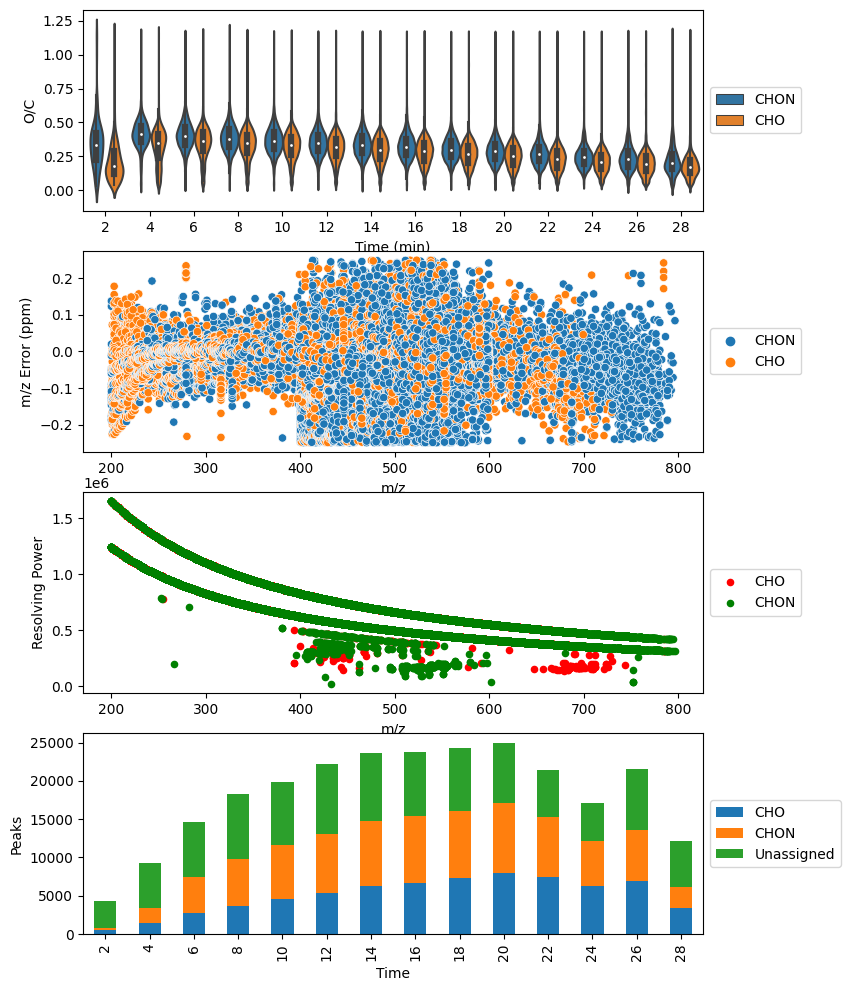

In [20]:
data.assess_all_results() ## why is it necessary to run this to get self.complete_results_df?

In [21]:
# add 'm/z window' and 'rep' columns

data_df = data.complete_results_df

data_df = add_mzwindow_col(data_df)

data_df = addRepCol(data_df)

print(data_df['m/z window'].unique())
print(data_df['Rep'].unique())
print(data_df['file'].unique())

20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw
[2 1]
['200-1200 m/z' '400-500 m/z' '400-600 m/z' '500-600 m/z']
[2 1]
['20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_

In [22]:
# save assignment results as pd dataframe and export as .csv 
data_df.to_csv("/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/spring-max600mz_22-11-30_Cu.csv")


In [23]:
#create subsets of assignments based m/z window

list100mz = []
list200mz = []
listfullzmz = [] 

for mzwindow in data_df['m/z window'].unique():

    r_df = data_df[data_df['m/z window'] == mzwindow]

    if (mzwindow == '400-600 m/z') or (mzwindow == '600-800 m/z'):
        list200mz.append(r_df)

    elif (mzwindow == '400-500 m/z') or (mzwindow == '500-600 m/z') or (mzwindow == '600-700 m/z') or (mzwindow == '700-800 m/z'):
        list100mz.append(r_df) 

    elif (mzwindow == '200-1200 m/z'):
        listfullzmz.append(r_df) 

mz100 = pd.concat(list100mz)
mz200 = pd.concat(list200mz)
mzfull = pd.concat(listfullzmz)


In [ ]:
# plot assignment error distribution for full data set
pltMZerror(assignMolClass(data_df))

plt.show()

pltMZerror_pts(assignMolClass(data_df))

plt.show()

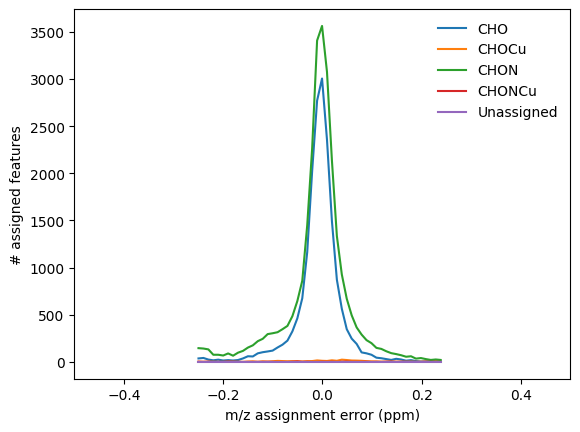

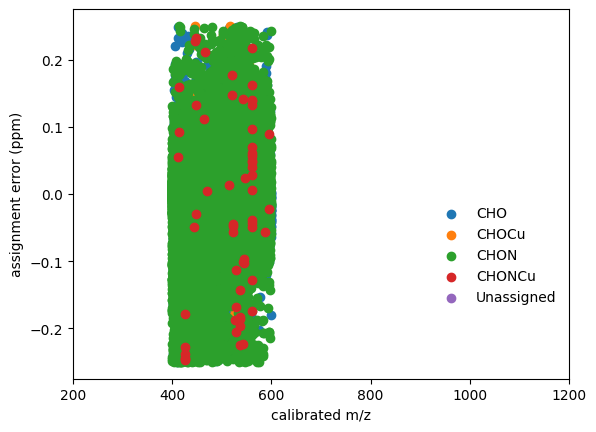

In [27]:
# plot assignment error dist for m/z 100 scans
pltMZerror(assignMolClass(mz100))

plt.show()

pltMZerror_pts(assignMolClass(mz100))

plt.show()

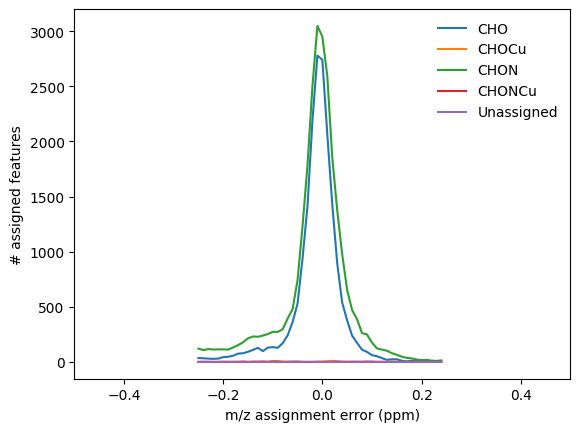

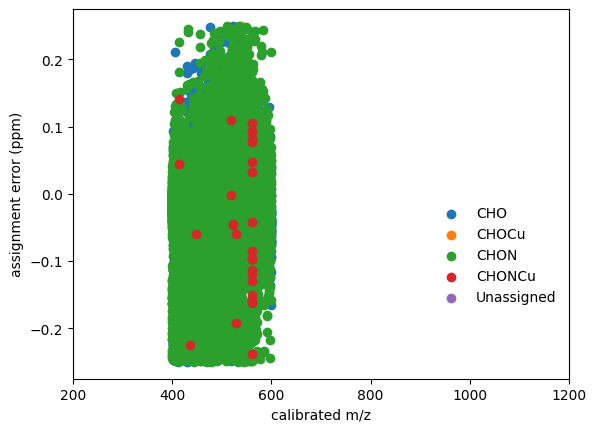

In [26]:
# plot assignment error dist for m/z 200 scans
pltMZerror(assignMolClass(mz200))

plt.show()

pltMZerror_pts(assignMolClass(mz200))

plt.show()

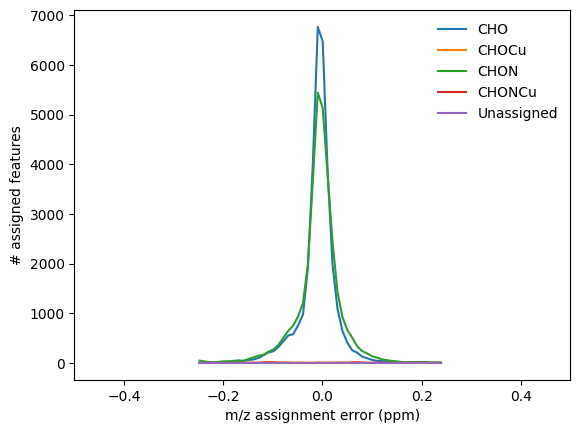

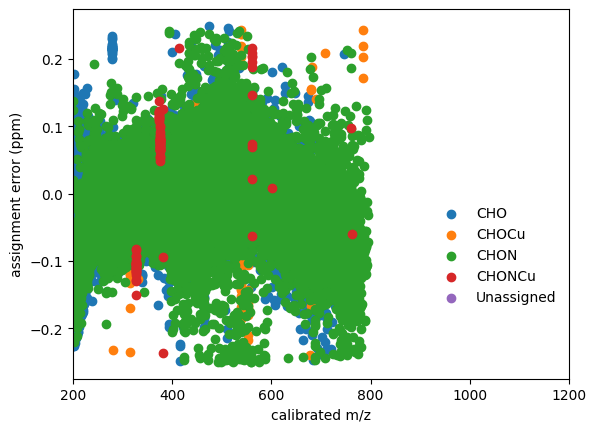

In [25]:
# plot assignment error dist for full m/z scans 
pltMZerror(assignMolClass(mzfull))

plt.show()

pltMZerror_pts(assignMolClass(mzfull))

plt.show()

In [28]:
assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_200mz = mz200[~mz200['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

print('400-600 m/z, 100 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz100)[0],  np.shape(assigned_100mz)[0], np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100))
print('400-600 m/z, 200 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz200)[0], np.shape(assigned_200mz)[0], np.shape(assigned_200mz)[0] / np.shape(mz200)[0] * 100))
print('200-800 m/z window (full scan): \n%s features total; %s assigned (%.1f%%)' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100))

print('\n\n')

unique_100mz = getUniqueFeatures(assigned_100mz)
unique_200mz = getUniqueFeatures(assigned_200mz)
unique_fullmz = getUniqueFeatures(assigned_fullmz)


400-600 m/z, 100 m/z windowing: 
98009 features total; 51038 assigned (52.1%)
400-600 m/z, 200 m/z windowing: 
83208 features total; 49304 assigned (59.3%)
200-800 m/z window (full scan): 
123094 features total; 75480 assigned (61.3%)



total # results: 51038
# unique results: 29971
total # results: 49304
# unique results: 26187
total # results: 75480
# unique results: 38126


In [29]:
assigned_100mz_456 = assigned_100mz[(assigned_100mz['m/z']>=400)]
assigned_100mz_456 = assigned_100mz_456[(assigned_100mz_456['m/z']<=600)]

assigned_200mz_456 = assigned_200mz[(assigned_200mz['m/z']>=400)]
assigned_200mz_456 = assigned_200mz_456[(assigned_200mz_456['m/z']<=600)]

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=400)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=600)]

mz100_456 = mz100[(mz100['m/z']>=400)]
mz100_456 = mz100_456[(mz100_456['m/z']<=600)]

mz200_456 = mz200[(mz200['m/z']>=400)]
mz200_456 = mz200_456[(mz200_456['m/z']<=600)]

mzfull_456 = mzfull[(mzfull['m/z']>=400)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=600)]

print('400-600 m/z, 100 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz100_456)[0],  np.shape(assigned_100mz_456)[0], np.shape(assigned_100mz_456)[0] / np.shape(mz100_456)[0] * 100))
print('\n400-600 m/z, 200 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz200_456)[0], np.shape(assigned_200mz_456)[0], np.shape(assigned_200mz_456)[0] / np.shape(mz200_456)[0] * 100))
print('\n400-600 m/z, full window: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100))



400-600 m/z, 100 m/z windowing: 
98009 features total
51038 assigned (52.1%)

400-600 m/z, 200 m/z windowing: 
83208 features total
49304 assigned (59.3%)

400-600 m/z, full window: 
56611 features total
33034 assigned (58.4%)


In [30]:

unique_100mz_456 = getUniqueFeatures(assigned_100mz_456)
unique_200mz_456 = getUniqueFeatures(assigned_200mz_456)
unique_fullmz_456 = getUniqueFeatures(assigned_fullmz_456)

total # results: 51038
# unique results: 29971
total # results: 49304
# unique results: 26187
total # results: 33034
# unique results: 17179


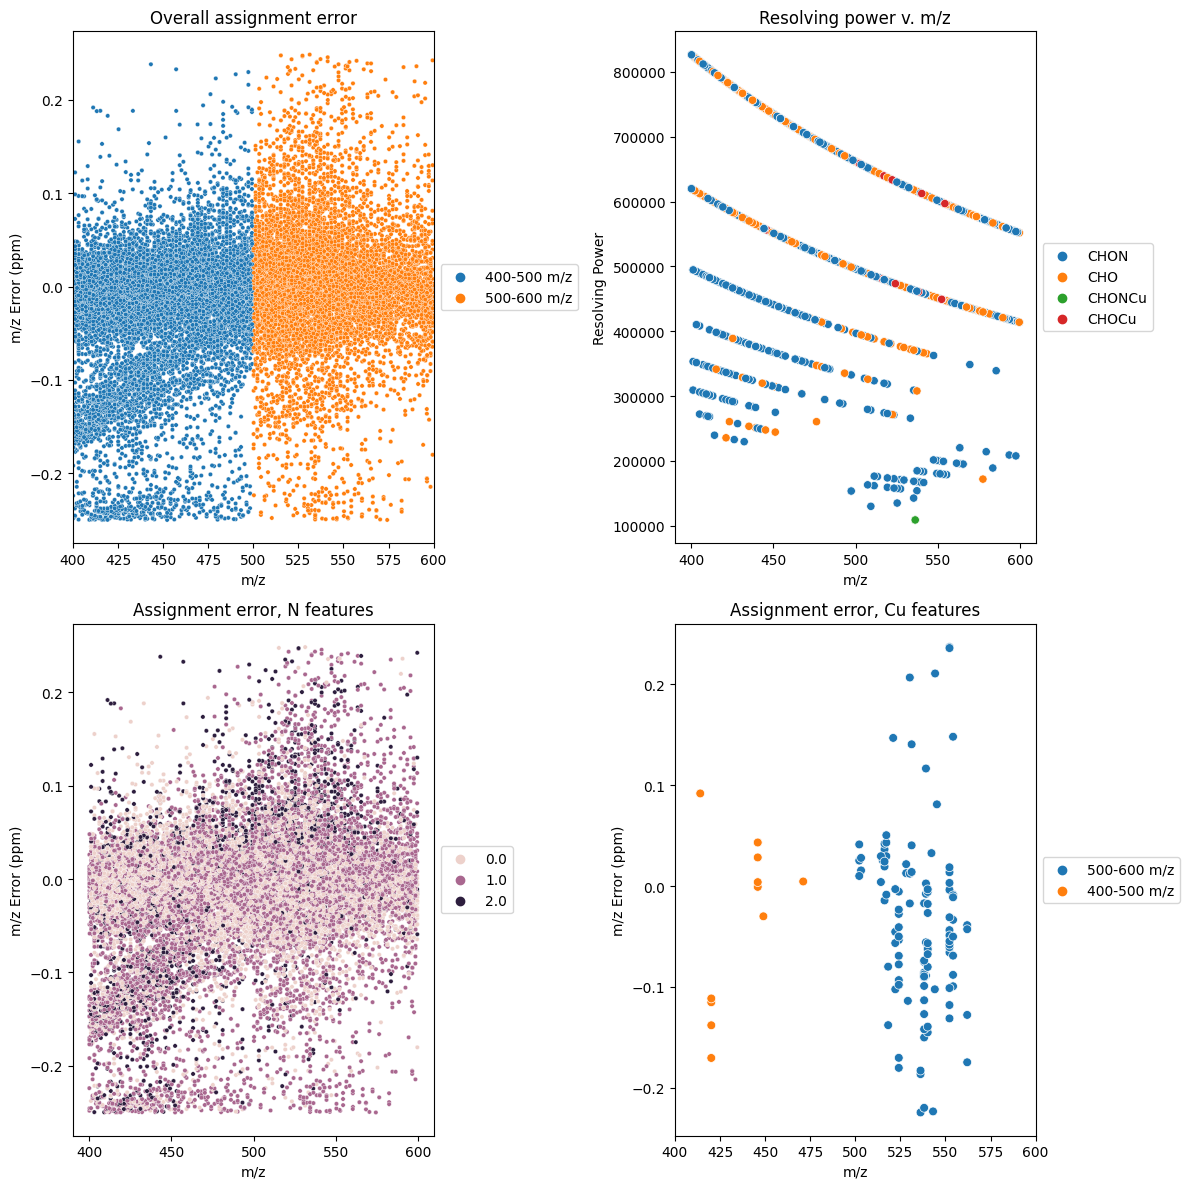

['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw']


In [31]:
# 100 m/z window, error plots with blanks removed 
mask = ~unique_100mz_456['file'].str.contains('qh2o', case=False, na=False)
unique_100mz_nb=unique_100mz_456[mask]
df = assignMolClass(unique_100mz_nb)

fig = plotUnique(df,ps=10)
plt.tight_layout()
plt.show()
print(unique_100mz_nb['file'].unique())

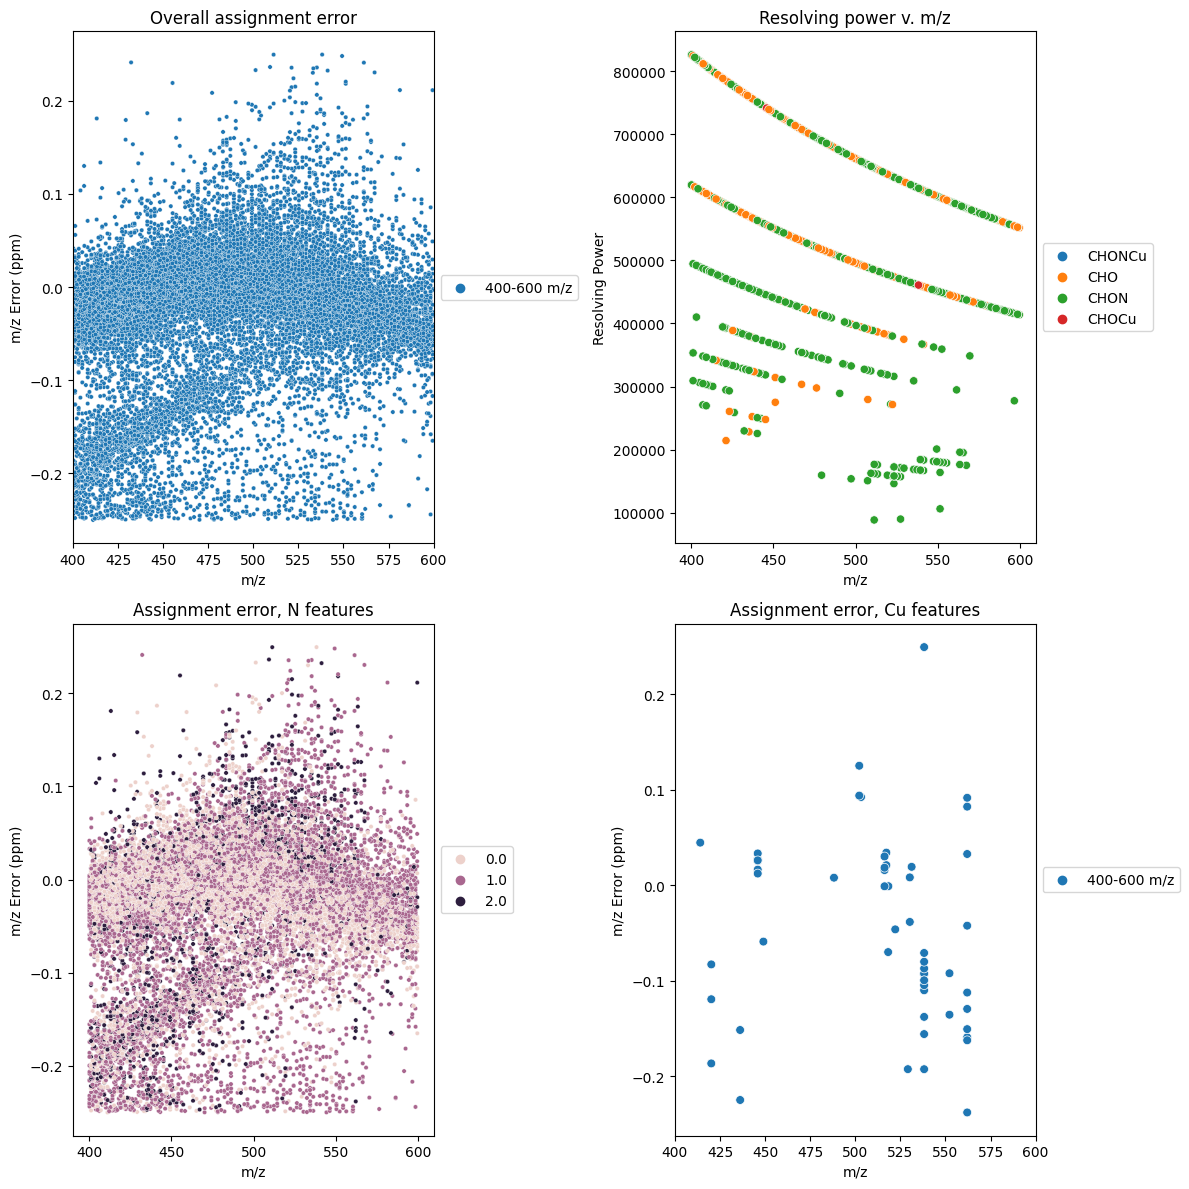

['20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw']


In [32]:
# 200 m/z window, error plots with blanks removed 

mask = ~unique_200mz_456['file'].str.contains('qh2o', case=False, na=False)
unique_200mz_nb=unique_200mz_456[mask]


fig = plotUnique(assignMolClass(unique_200mz_nb),ps=10)
plt.tight_layout()
plt.show()
plt.close('all')

print(unique_200mz_nb['file'].unique())

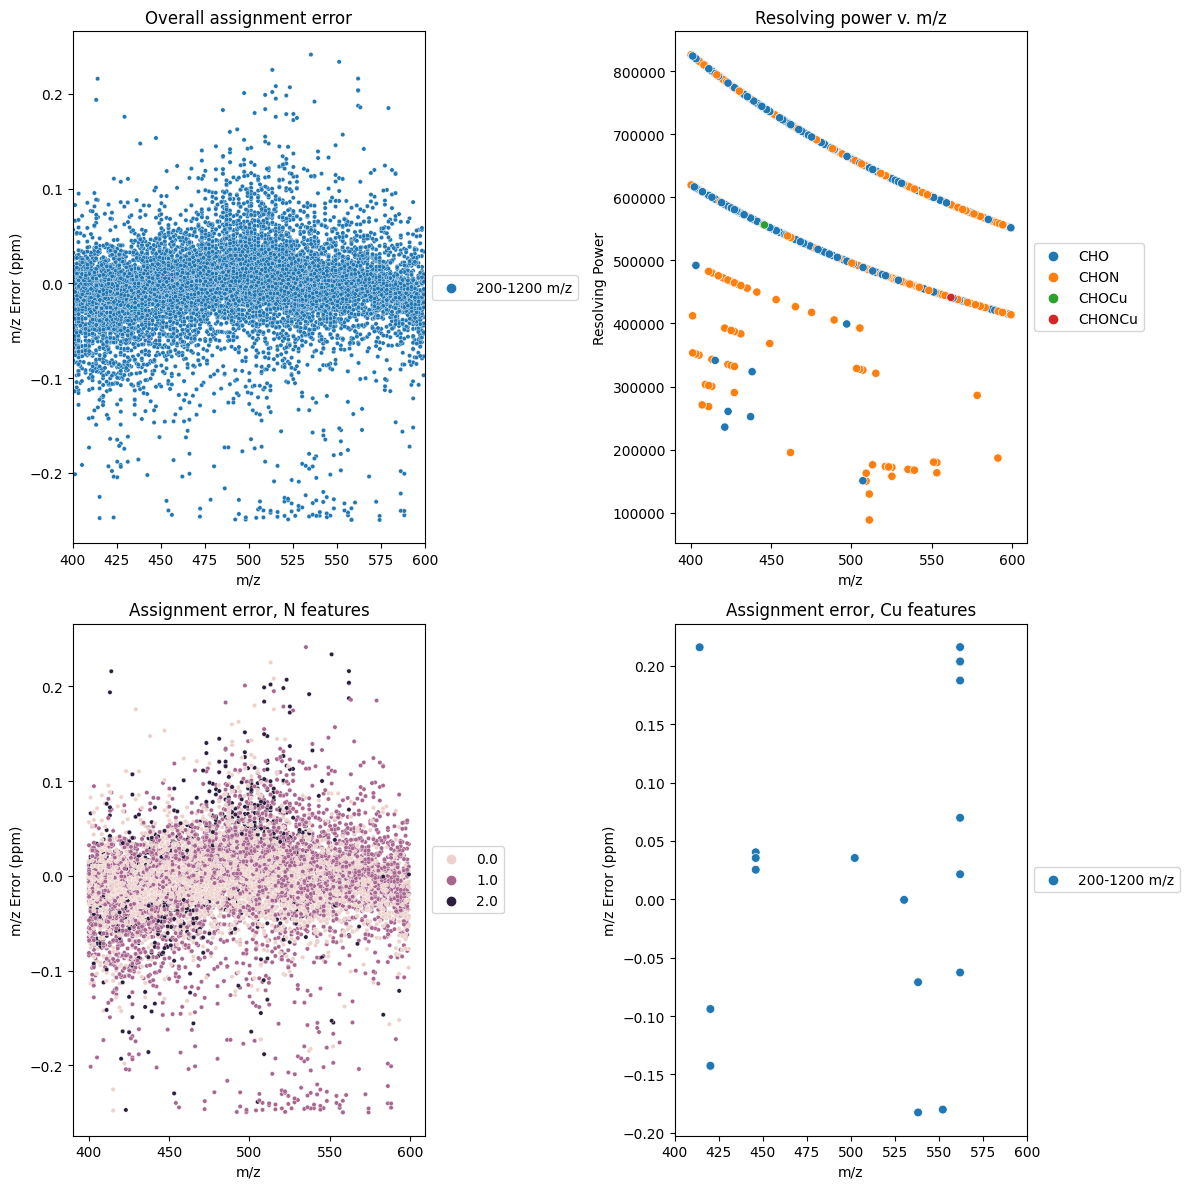

['20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw']


In [33]:
# full m/z window, error plots with blanks removed 

mask = ~unique_fullmz_456['file'].str.contains('qh2o', case=False, na=False)
unique_fullmz_nb=unique_fullmz_456[mask]


fig = plotUnique(assignMolClass(unique_fullmz_nb),ps=10)
plt.tight_layout()
plt.show()
plt.close('all')

print(unique_fullmz_nb['file'].unique())

In [34]:
# create 200 m/z blank files from 100 m/z blank files (did not collect 200 m/z blank files)

blank_files = [f for f in data._raw_filelist if 'qh2o' in f]

blank_data = []

for f in blank_files:

    if 'fullmz' not in f:
        
        temp = data_df[data_df['file'] == f] 

        blank_data.append(temp)

blanks_df = pd.concat(blank_data)

rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
rep1_temp = rep1_temp[rep1_temp['m/z'] <= 600]
rep1_temp['file'] = 'mz200_400_600_blnk'
rep1_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])

#rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
#rep1_temp = rep1_temp[rep1_temp['m/z'] >= 600]
#rep1_temp['file'] = 'mz200_600_800_blnk'
#rep1_temp['m/z window'] = '600-800 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])


rep2_temp = blanks_df[blanks_df['file'].str.contains('rep2')]
rep2_temp = rep2_temp[rep2_temp['m/z'] <= 600]
rep2_temp['file'] = 'mz200_400_600_blnk_rep2'
rep2_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep2_temp])

#rep2_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
#rep2_temp = rep2_temp[rep2_temp['m/z'] >= 600]
#rep2_temp['file'] = 'mz200_600_800_blnk_rep2'
#rep2_temp['m/z window'] = '600-800 m/z'

blanks_df = pd.concat([blanks_df,rep2_temp])

print(blanks_df['file'].unique())

print(blanks_df['m/z window'].unique())



['20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw' 'mz200_400_600_blnk'
 'mz200_400_600_blnk_rep2']
['500-600 m/z' '400-500 m/z' '400-600 m/z']


In [35]:
# add 200 m/z blank data to master df

mz200_blanks = blanks_df[blanks_df['m/z window'] == '400-600 m/z']
data_df = pd.concat([data_df, mz200_blanks])

for f in data_df['file'].unique():
    print(f)




20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw
mz200_400_600_blnk
mz200_400_600_blnk_rep2


In [36]:
# add fullmz blanks to blanks df
blanks_df = pd.concat([blanks_df, data_df[data_df['file'] =='20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw' ]])
blanks_df = pd.concat([blanks_df, data_df[data_df['file'] =='20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw' ]])

print(blanks_df['m/z window'].unique())

['500-600 m/z' '400-500 m/z' '400-600 m/z' '200-1200 m/z']


In [37]:
# add column with blank file identity to use in blank subtraction
df_backup = data_df
df_backup.to_csv("/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/spring-max600mz_backup.csv")

data_df['blank file'] = data_df.index

for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window

    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]


        temp2['blank file'] = btemp2['file'].iloc[0]

        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2


print(data_df['blank file'].unique())

['20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw'
 'mz200_400_600_blnk'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw'
 'mz200_400_600_blnk_rep2']


In [38]:
def blankSubtract(df, blnkthresh = 0.9):
    
    holder = []
    for file in df['file'].unique():
        
        #if file == 
        sub = df[df['file'] == file]

        blkf = sub['blank file'].iloc[0]


        sub[sub[file]== np.nan] = 0

        nom = sub[file]
        den = sub[blkf]

        nom = nom.replace(np.nan,0)
        den = den.replace(np.nan,1)

        if file != blkf:
            nom = nom
        elif file == blkf:
            nom = nom * (blnkthresh*0.8)

        sub['blank subtract'] = nom/den
        holder.append(sub)
    df_end = pd.concat(holder)
    df_end = df_end[df_end['blank subtract'] > blnkthresh]
    return df_end

In [39]:
df_unique = getUniqueFeatures(data_df)


total # results: 344893
# unique results: 52041


In [40]:
df_bs = blankSubtract(df_unique, blnkthresh=0.3)


(38865, 52)


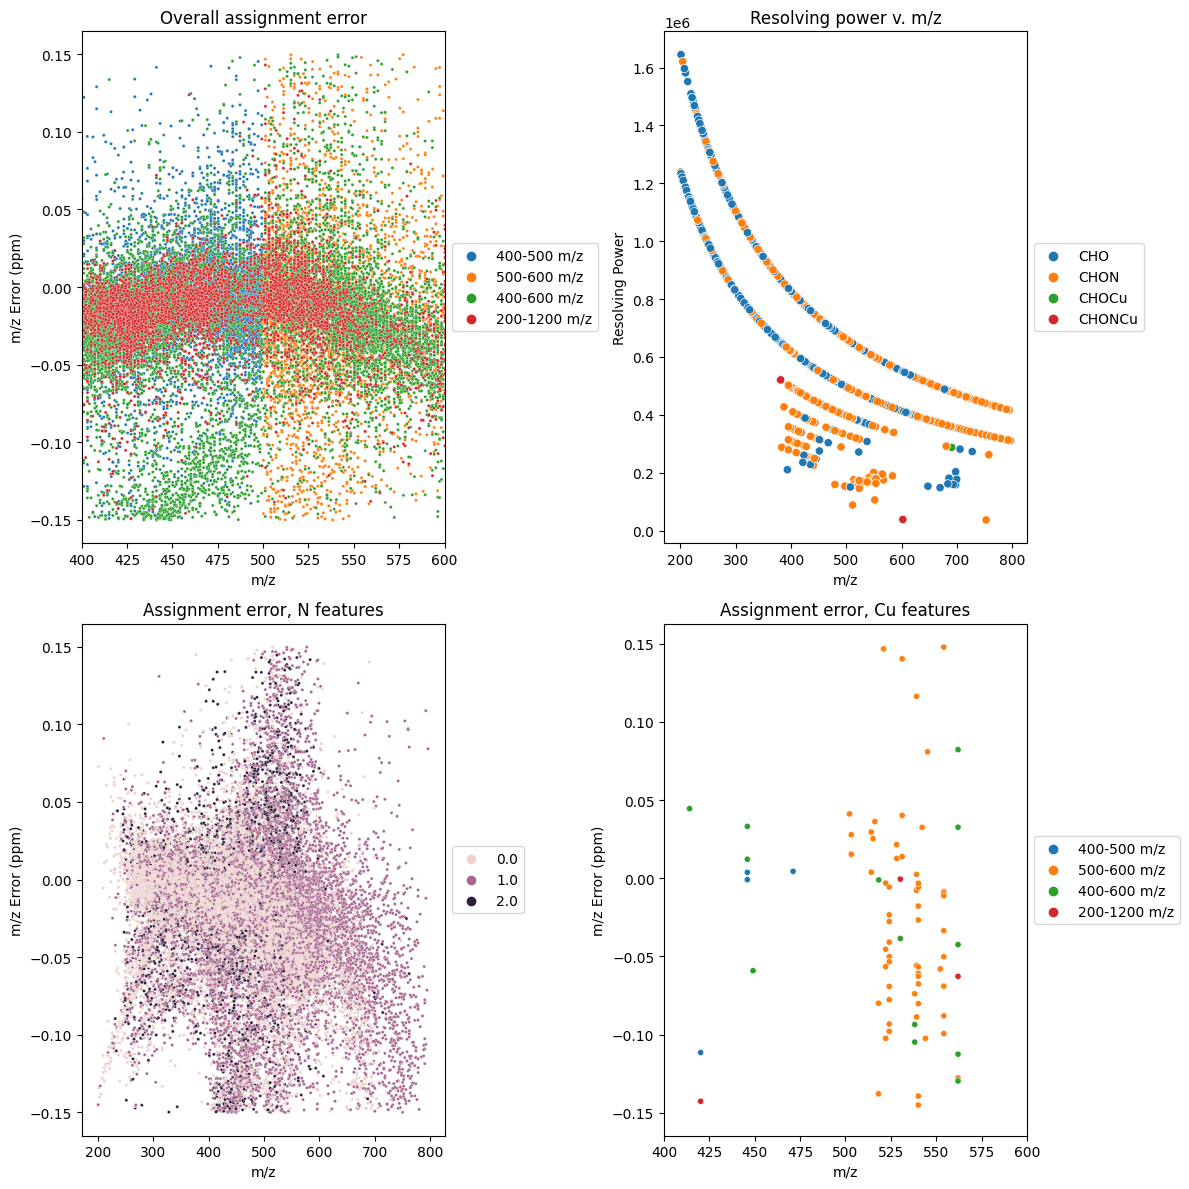

In [41]:
temp = df_bs[abs(df_bs['m/z Error (ppm)'])<0.15]
print(np.shape(temp))
fig = plotUnique(assignMolClass(pd.concat([temp[temp['m/z window']== '400-500 m/z'], temp[temp['m/z window']=='500-600 m/z'], temp[temp['m/z window']=='400-600 m/z'], temp[temp['m/z window']=='200-1200 m/z']])),ps=5)

plt.tight_layout()
plt.show()
plt.close('all')

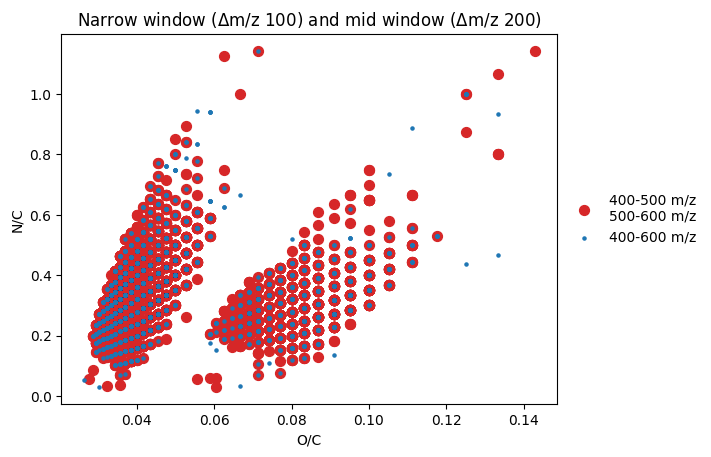

In [42]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs
df2 = mz200_bs
df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',s=50,label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#sns.scatterplot(x='N/C',y='O/C', hue='m/z', data=df, ax=ax,s=50)
ax.scatter(x=df2['N/C'],y=df2['O/C'],c='C0',s=5,label='400-600 m/z') #s=df2['S/N'],
#ax.scatter(x=df3['N/C'],y=df3['O/C'],c='C5',label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and mid window ($\Delta$m/z 200)')
plt.show()


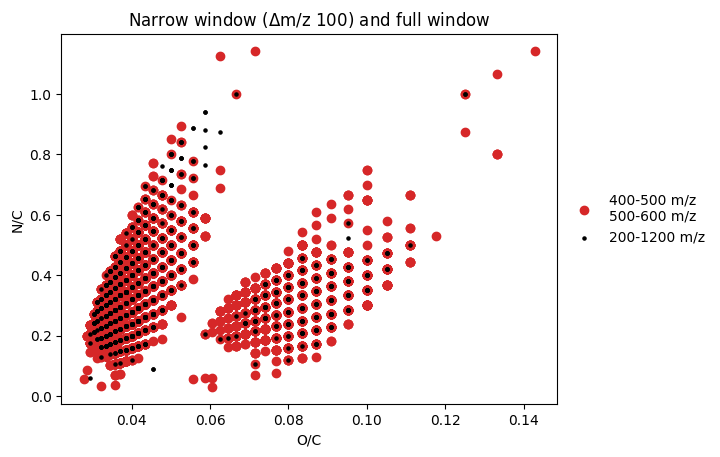

In [43]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs
df2 = mz200_bs
df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#ax.scatter(x=df2['N/C'],y=df2['O/C'],c='black',s=5,label='400-600 m/z') #s=df2['S/N'],
ax.scatter(x=df3['N/C'],y=df3['O/C'],c='black',s=5,label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and full window')
plt.show()


In [44]:
temp = df_bs[df_bs['m/z'] >= 400]
temp = temp[temp['m/z']<=600]

temp['m/z Window Size'] = temp.Index

for i in range(len(temp['m/z window'])):

    w = temp['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '1000 m/z'

In [46]:
mz100_contains_cu = mz100_bs[(mz100_bs['Cu'] == 1) ]
print(np.shape(mz100_contains_cu))
mz100_cu_limited_err = mz100_contains_cu[abs(mz100_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mz100_cu_limited_err))

mz200_contains_cu = mz200_bs[(mz200_bs['Cu'] == 1) ]
print(np.shape(mz200_contains_cu))
mz200_cu_limited_err = mz200_contains_cu[abs(mz200_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mz200_cu_limited_err))

mzfull_contains_cu = mzfull_bs[(mzfull_bs['Cu'] == 1)]
print(np.shape(mzfull_contains_cu))
mzfull_cu_limited_err = mzfull_contains_cu[abs(mzfull_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mzfull_cu_limited_err))


(107, 52)
(91, 52)
(25, 52)
(22, 52)
(8, 52)
(7, 52)


In [47]:
temp = temp[temp['Cu'] == 1]

temp['overlap'] = temp.Index

for i in range(len(temp['Molecular Formula'])):

    mf = temp['Molecular Formula'].iloc[i]

    if (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        temp['overlap'].iloc[i] = 'n'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nw'

    elif (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nm'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nmw'



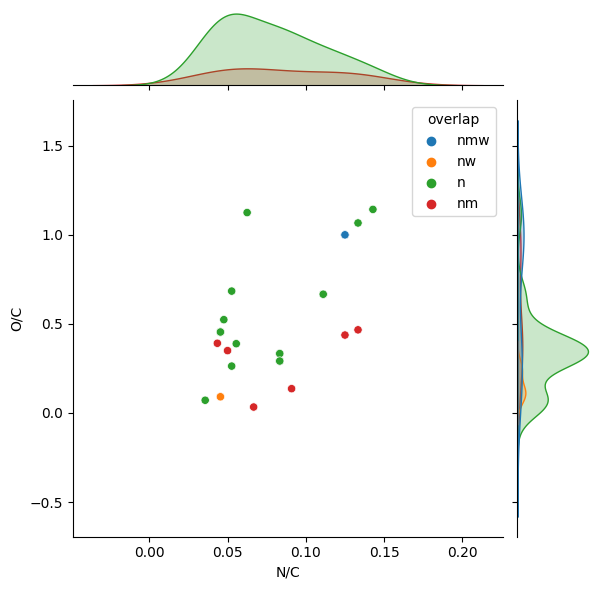

In [48]:
sns.jointplot(data=temp, x='N/C',y='O/C', hue='overlap')

In [49]:
print(np.shape(mzfull_cu_limited_err))
print(np.shape(mz100_cu_limited_err))

combo = pd.concat([mz100_cu_limited_err, mzfull_cu_limited_err])

combo['m/z Window Size'] = combo.Index

for i in range(len(combo['m/z window'])):

    w = combo['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '1000 m/z'

combo['m/z Window Size'].unique()

(7, 52)
(91, 52)


array(['100 m/z', '1000 m/z'], dtype=object)

In [54]:
mz100_cu_limited_err.columns

Index(['Index', 'm/z', 'Calibrated m/z', 'Calculated m/z', 'Peak Height',
       'Peak Area', 'Resolving Power', 'S/N', 'Ion Charge', 'm/z Error (ppm)',
       'm/z Error Score', 'Isotopologue Similarity', 'Confidence Score', 'DBE',
       'H/C', 'O/C', 'Heteroatom Class', 'Ion Type', 'Is Isotopologue',
       'Mono Isotopic Index', 'Molecular Formula', 'C', 'H', 'O', 'N', 'Cu',
       'Time', '13C', '18O', '15N', 'file', 'm/z window', 'Rep', 'blank file',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_qh2o_4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


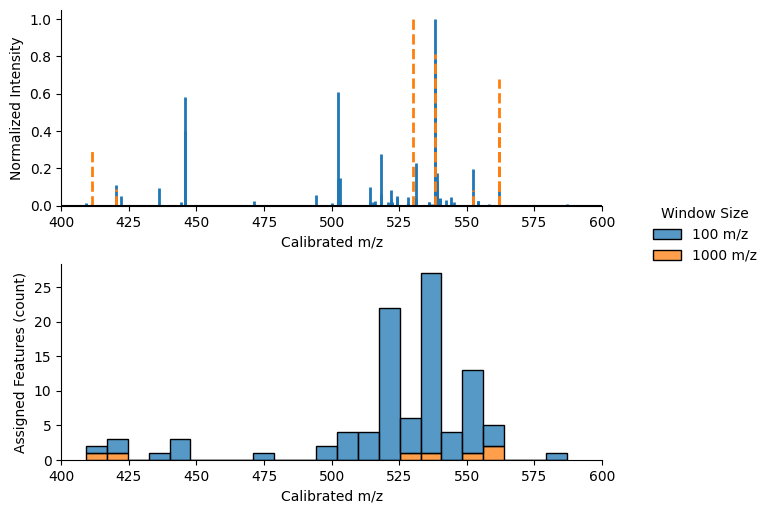

In [92]:
import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.02)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0], hspace = .05)

d1=normMS(mz100_cu_limited_err,mz100_cu_limited_err)
d2=normMS(mzfull_cu_limited_err,mzfull_cu_limited_err)

ax1_b = plt.subplot(gs1[0])
ax1_b = plot_ms(df1=d1,  df2=d2, start_mz=400, end_mz=600,ax_ms=ax1_b, norm=True)

sns.despine(ax=ax1_b)

ax1_b.set_ylim(bottom=0)





ax2 = plt.subplot(gs2[0])

sns.despine(ax=ax2)

sns.histplot(combo, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2)
ax2.set_ylabel('Assigned Features (count)')
ax2.set_xlim(400,600)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

plt.show()

In [ ]:
inds = np.where(np.asarray(mz100_EICdic[mf].time)<28)

np.asarray(mz100_EICdic[mf].time)[inds]

In [93]:
#data.master_data_holder['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'] #[file]={'parser': parser}
mz100_cu_limited_err = mz100_contains_cu[abs(mz100_contains_cu['m/z Error (ppm)']) < 0.25]
mz100_EICdic = {}
for mz,file,mf in zip(mz100_cu_limited_err['m/z'],mz100_cu_limited_err['file'],mz100_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']    
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    mz100_EICdic[mf]=EIC[0][mz]
    #mz100_EICdic[mz]={'eic':EIC[0][mz],'formula':mf}


In [94]:
mzfull_cu_limited_err = mzfull_contains_cu[abs(mzfull_contains_cu['m/z Error (ppm)']) < 0.25]
fullmz_EICdic = {}
for mz,file,mf in zip(mzfull_cu_limited_err['m/z'],mzfull_cu_limited_err['file'],mzfull_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    fullmz_EICdic[mf]=EIC[0][mz]

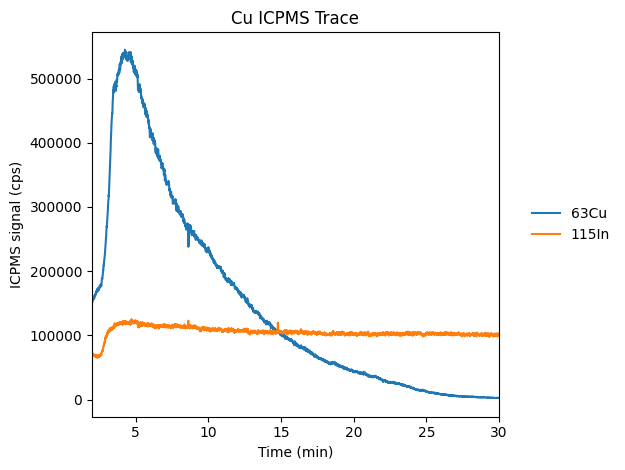

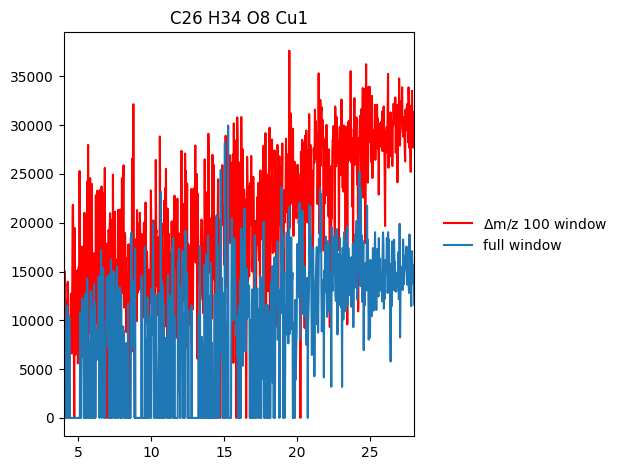

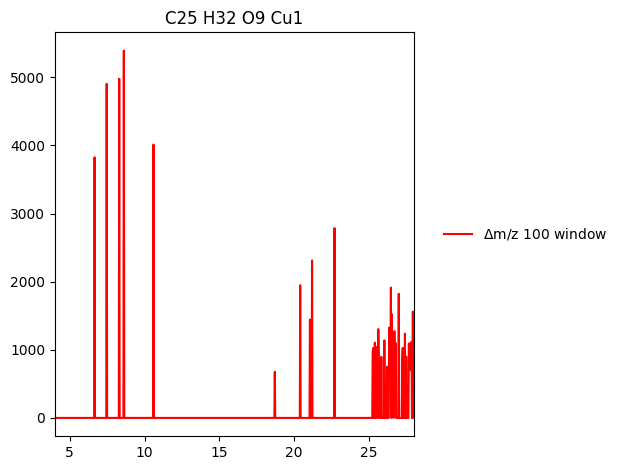

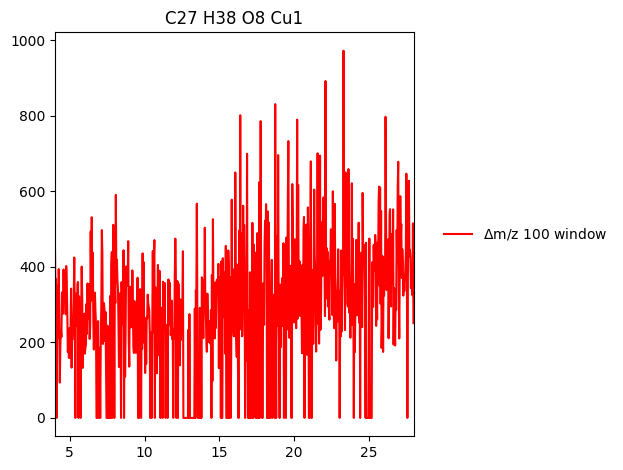

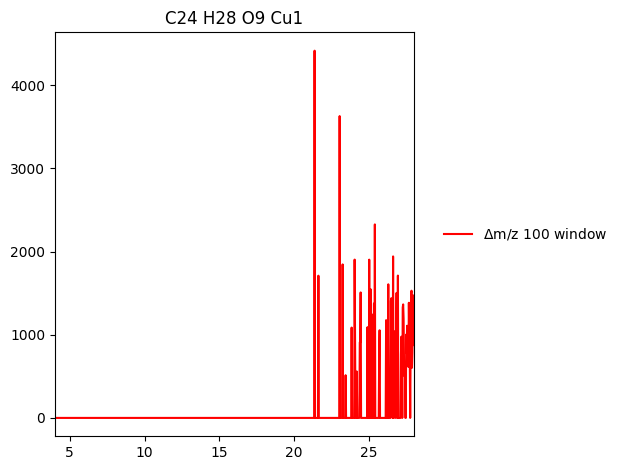

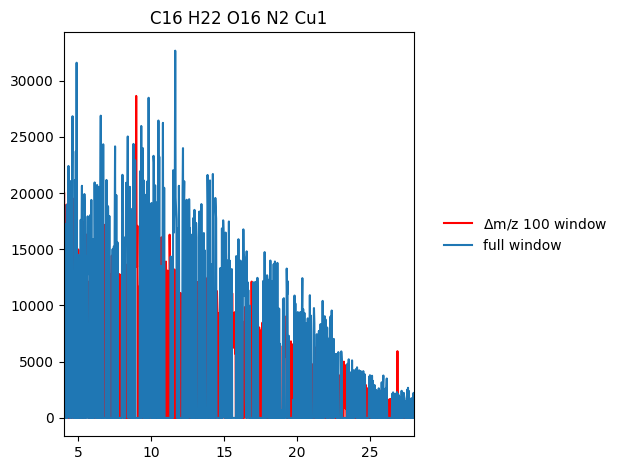

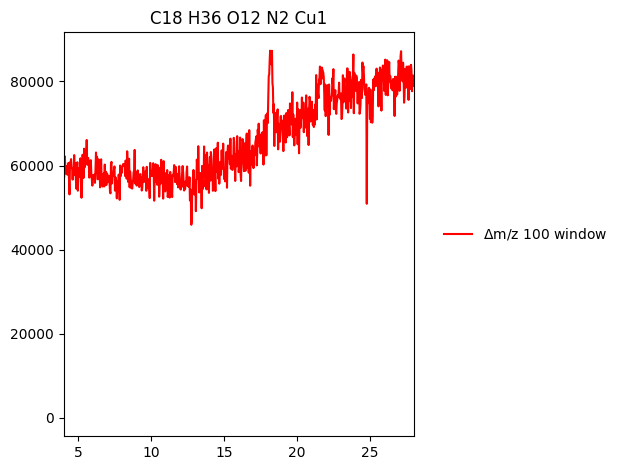

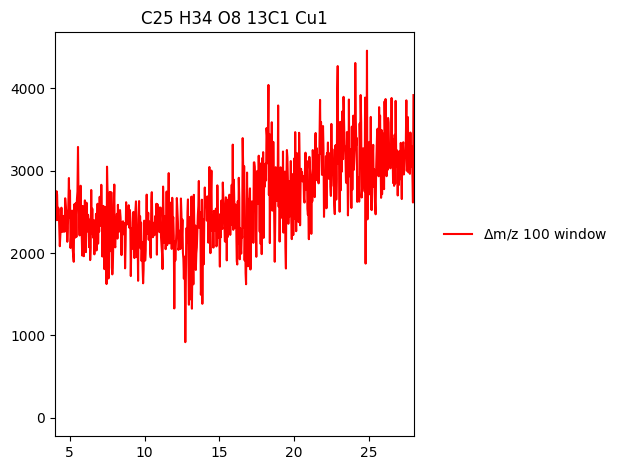

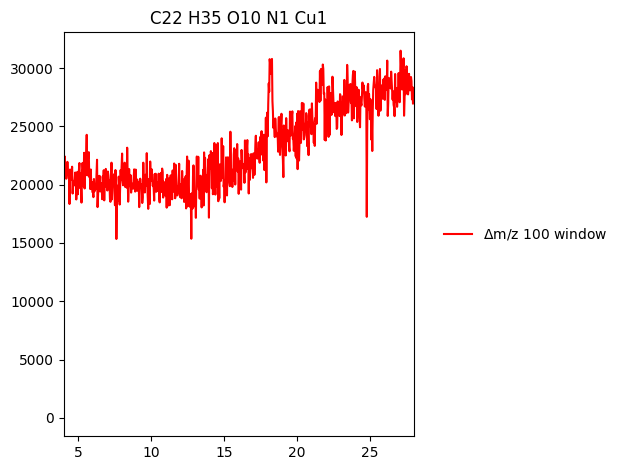

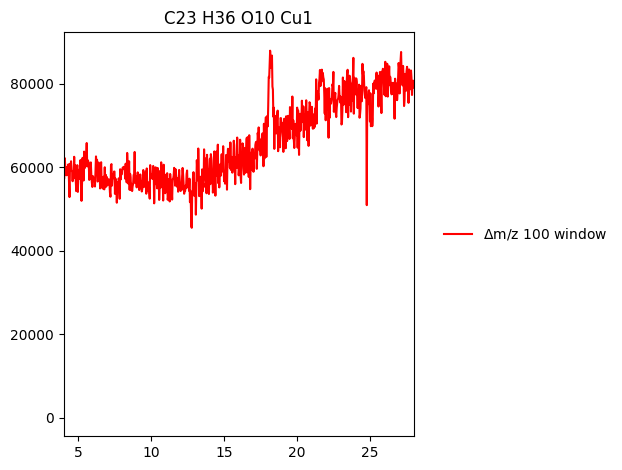

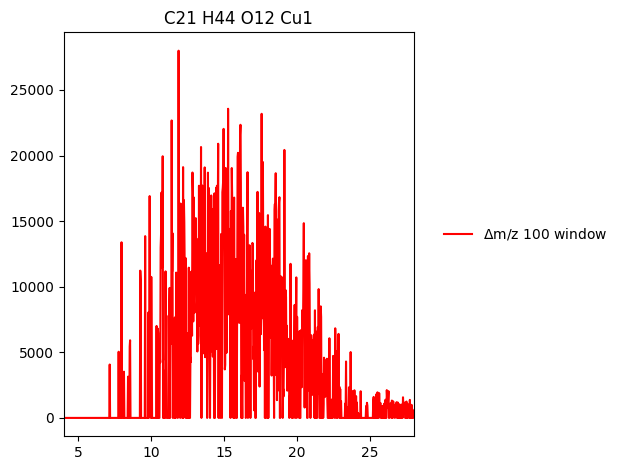

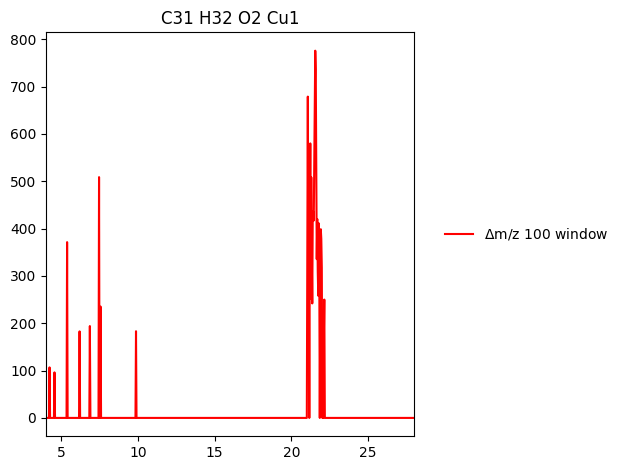

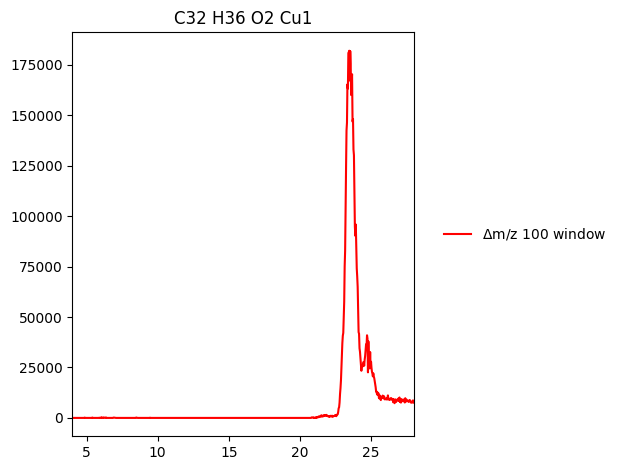

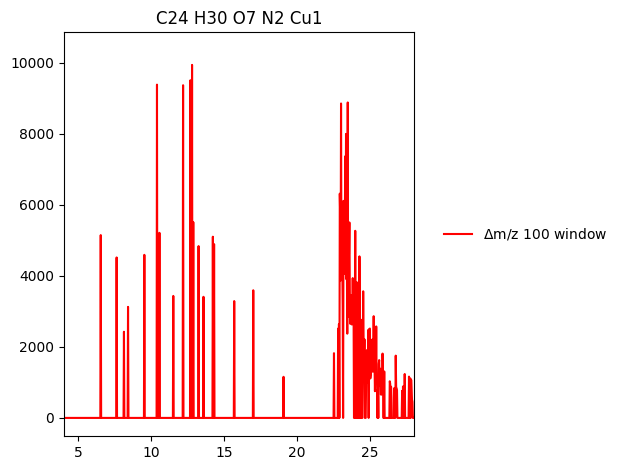

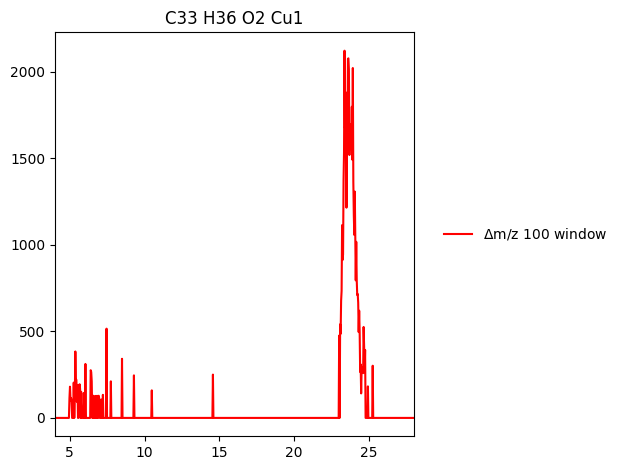

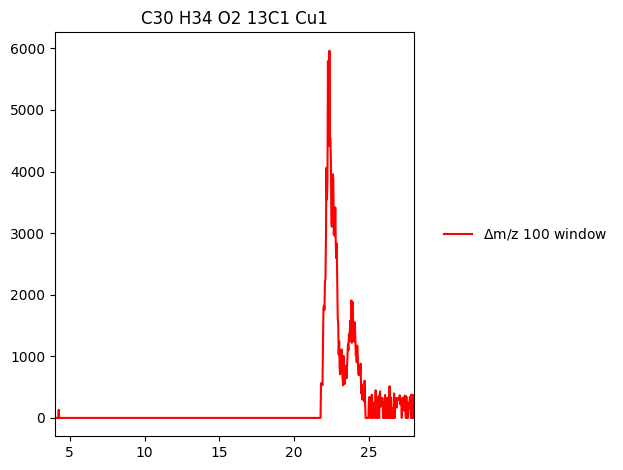

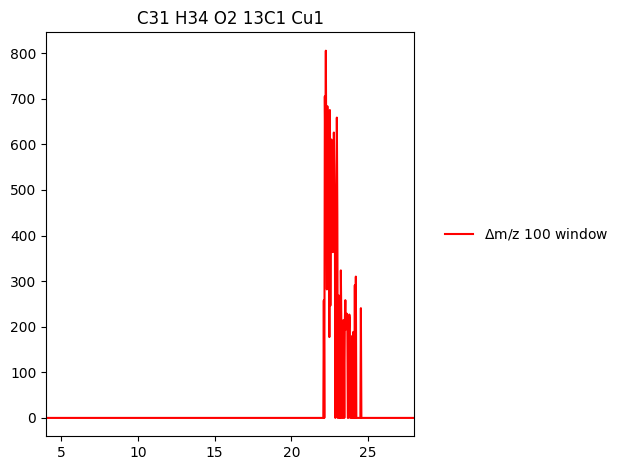

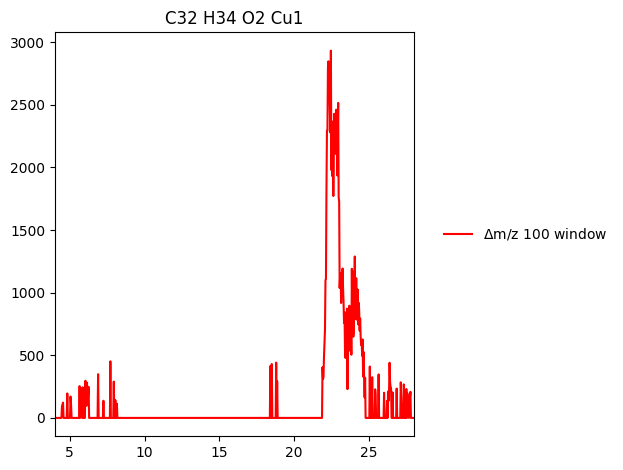

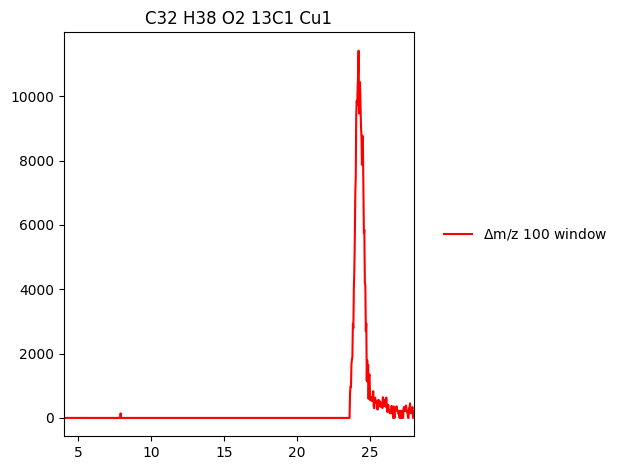

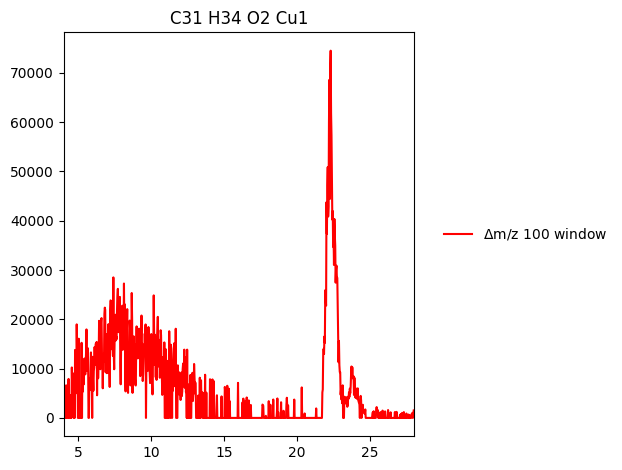

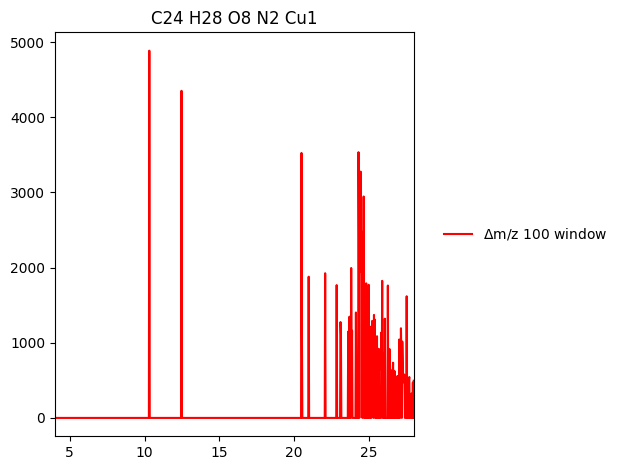

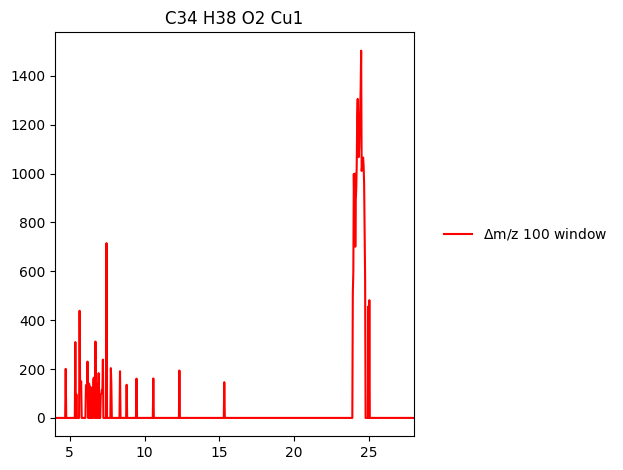

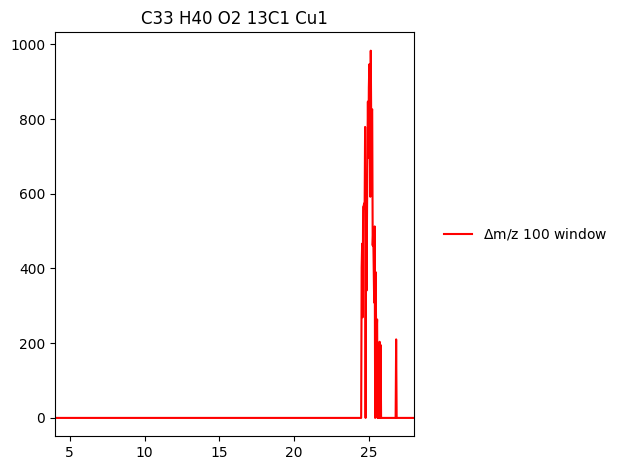

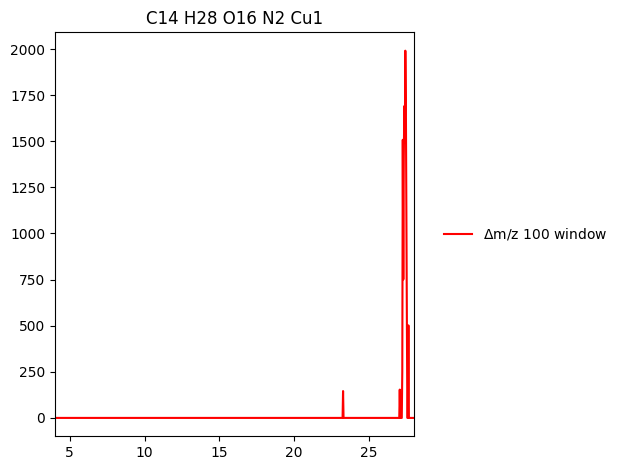

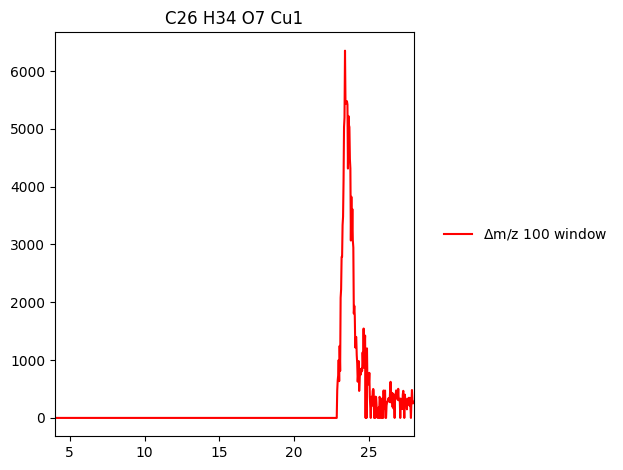

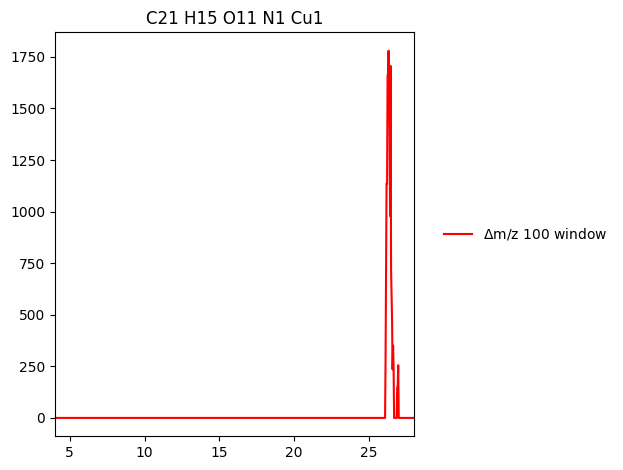

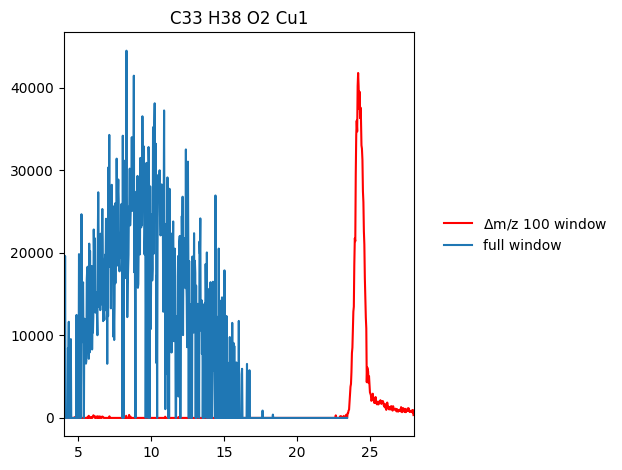

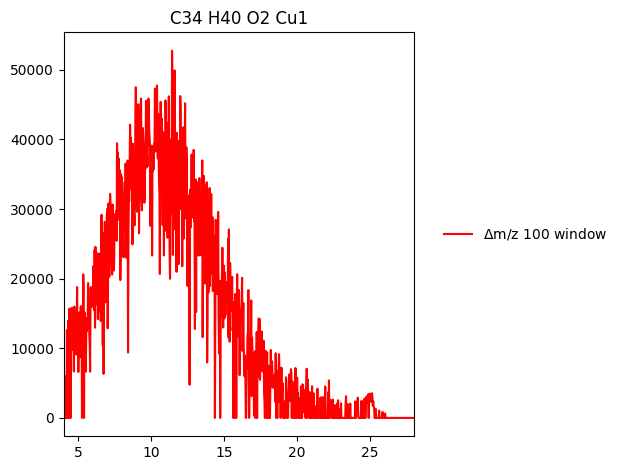

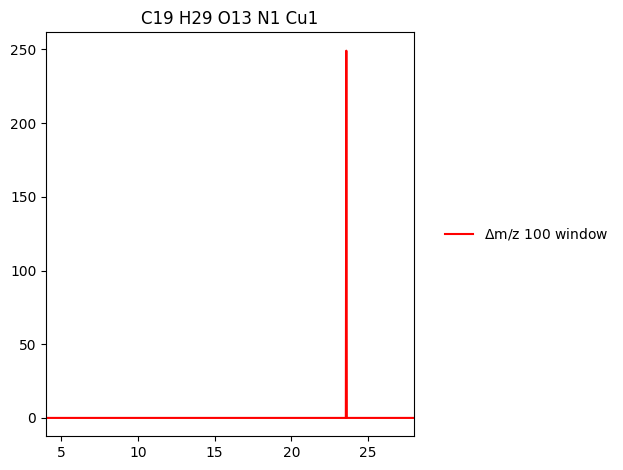

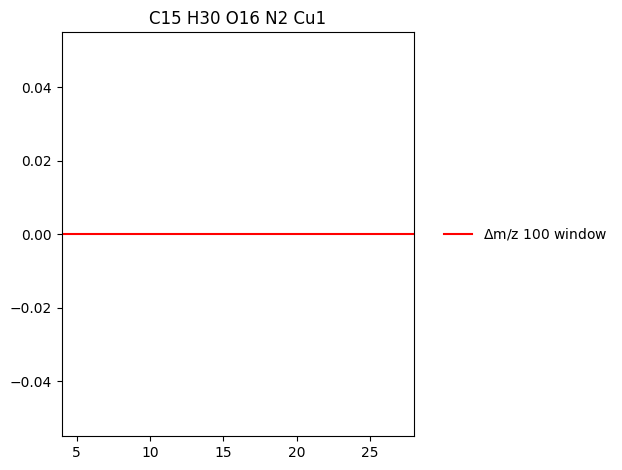

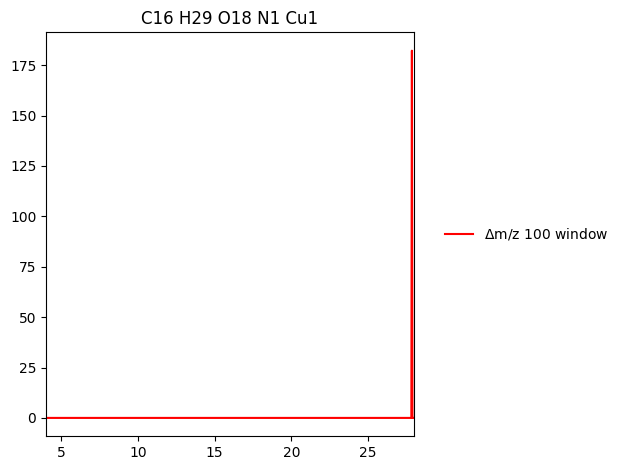

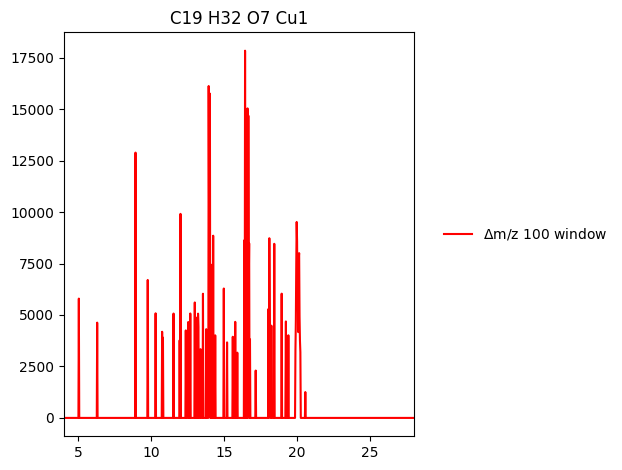

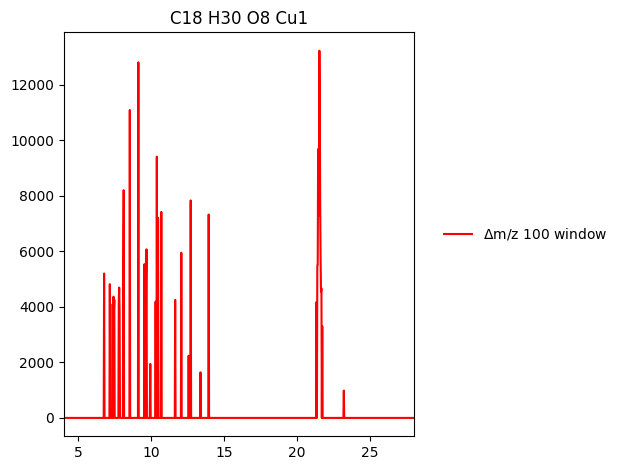

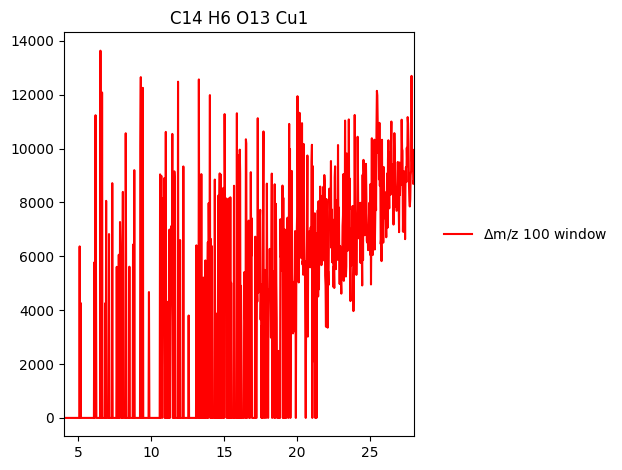

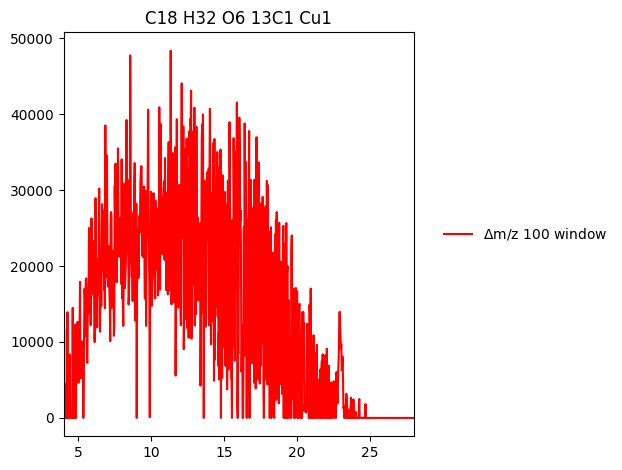

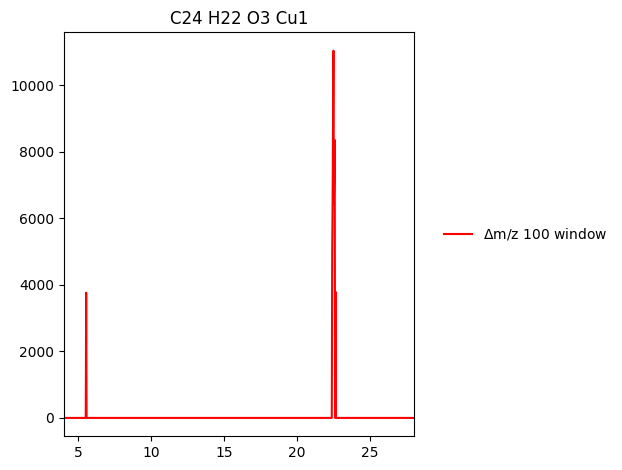

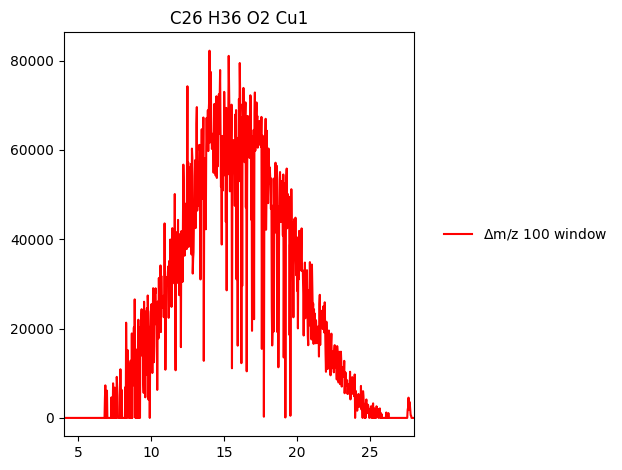

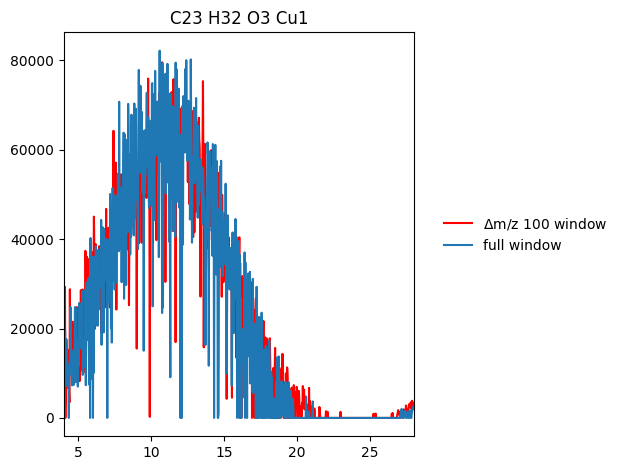

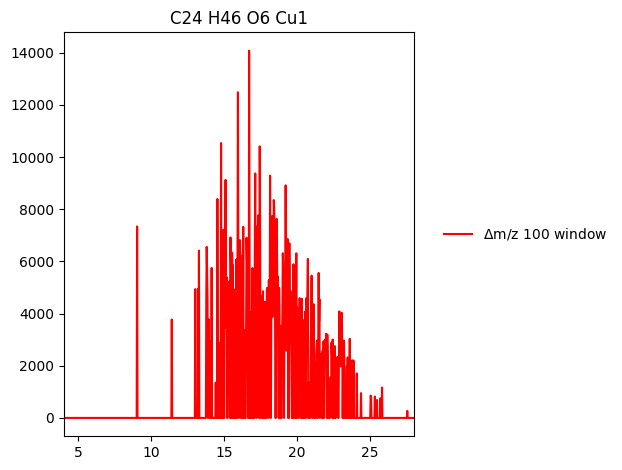

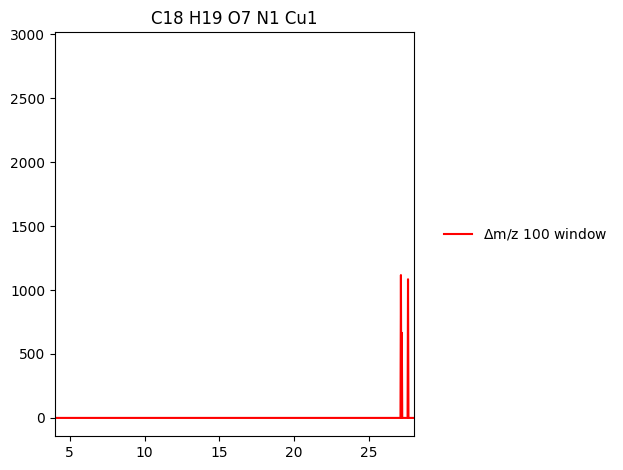

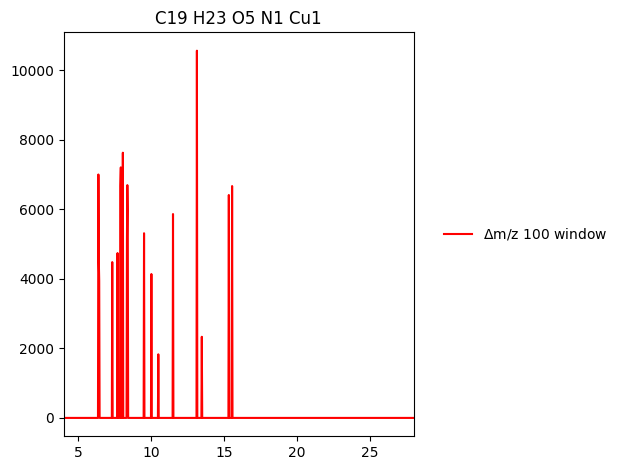

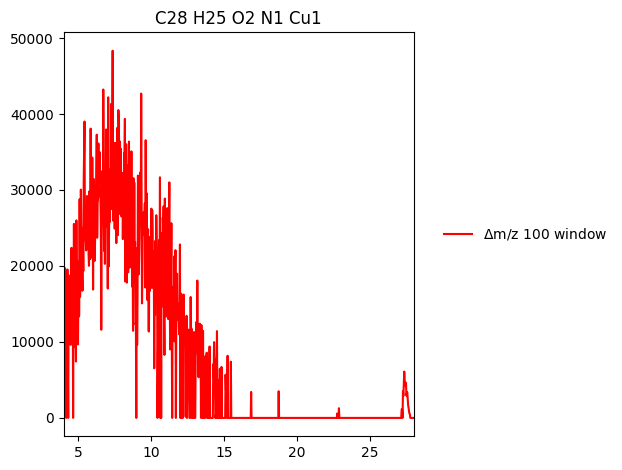

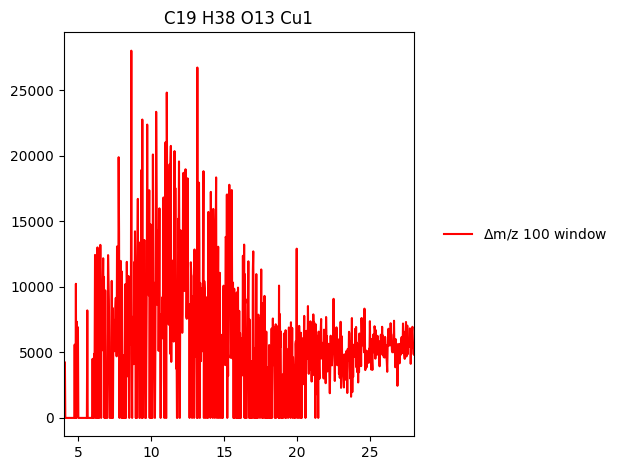

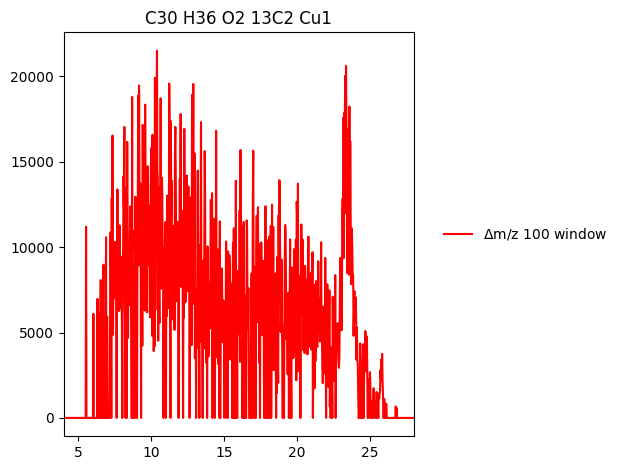

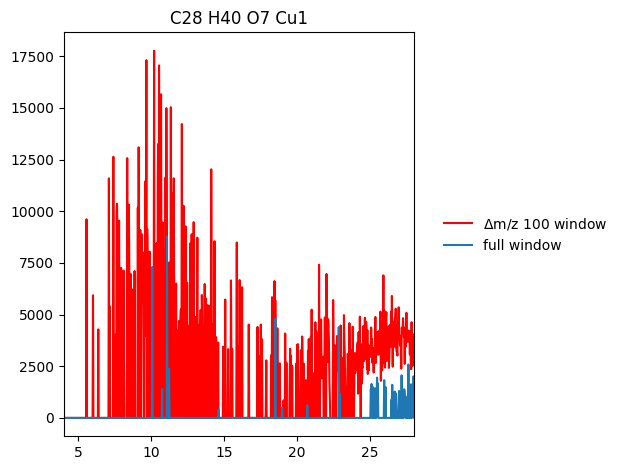

In [95]:
from matplotlib.backends.backend_pdf import PdfPages

icpms_file = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/spring_ENV.csv'
icpms = pd.read_csv(icpms_file, sep=';',header=1)


metals = ['63Cu', '115In']

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec1.pdf')

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Cu ICPMS Trace')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICPMS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(2,30)
fig.tight_layout()
pdf.savefig()

for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C3', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()